# Introduction

We'll now use the R package *MOVICS* to explore unsupervised clustering methods of multi-omic data, including SNF. Given clustering can pick up on different structures in the data, with each method having its own pros/cons and situations where it is best suited, it's important to compare various clustering methods. This will provide more robust results and help reduce identifying clusters based on an aberrant signal that a particular method may be identifying. *MOVICS* provides a user-friendly, well-integrated pipeline to perform clustering with 10 different methods as well as consensus clustering. Currently, it supports up to 6 omics data types for joint clustering. Furthermore, it offers numerous downstream analyses.

The methods include:
* SNF
* IntNMF
* LRAcluster
* NEMO
* PINSPlus
* CIMLR
* iClusterBayes
* MoCluster
* COCA
* ConsensusClustering


There is also an excellent vignette provided: https://xlucpu.github.io/MOVICS/MOVICS-VIGNETTE.html#Section.4.2.1.2

The overall pipeline is illustrated below (image from MOVICS documentation):

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    
if (!require("devtools")) 
    install.packages("devtools")
    
devtools::install_github("xlucpu/MOVICS")

install.packages(/Users/adamsj8/Library/CloudStorage/Box-Box/Zhang Lab/ASAShortCourse-MultiOmics/heatmap.plus_1.3.tar.gz, repos = NULL, type="source") # path to file is for the package source code you just downloaded

: 

In [1]:
## to install MOVICS
### note: there are many dependencies; you may get an error
### for a missing package; download and try again
### it may take several times
### you can refer to their IMPORTS file from their DESCRIPTION file on Github
### for a list of dependencies:
### https://github.com/xlucpu/MOVICS/blob/master/DESCRIPTION

# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# if (!require("devtools")) 
#     install.packages("devtools")
# devtools::install_github("xlucpu/MOVICS")

library(MOVICS)
set.seed(4444)

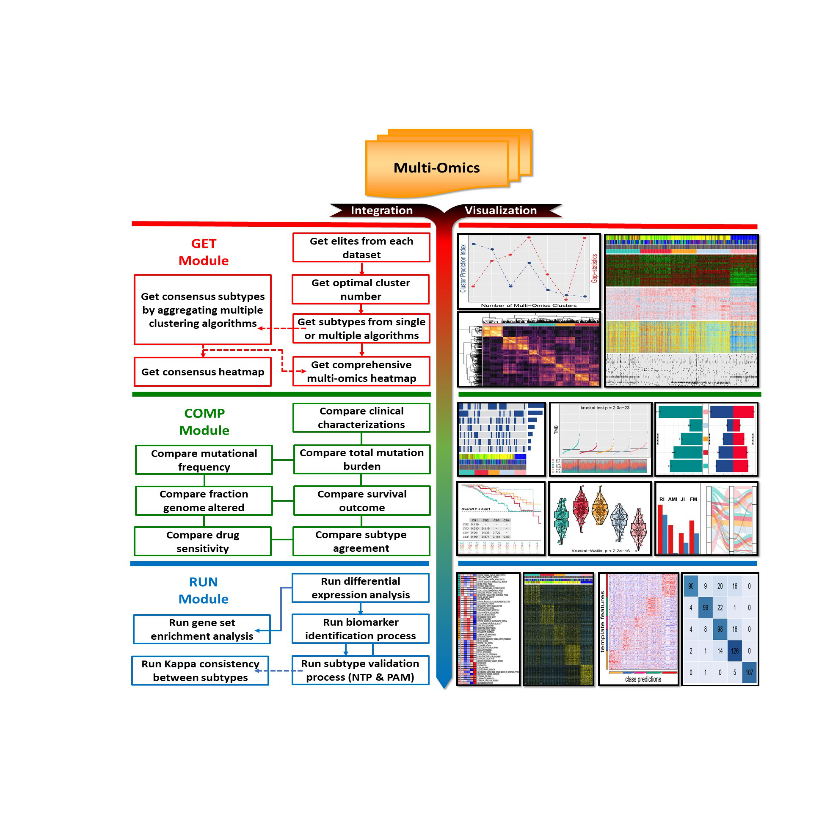

In [2]:
library("jpeg")
jj <- readJPEG("MOVICS_pipeline.jpeg",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)


And as a quick reminder from our presentation, here's a table from Zhang's 2021 paper (https://doi.org/10.1002/wics.1553) that provided a nice summary of a comparison between many of these methods and scenarios in which they're recommended.

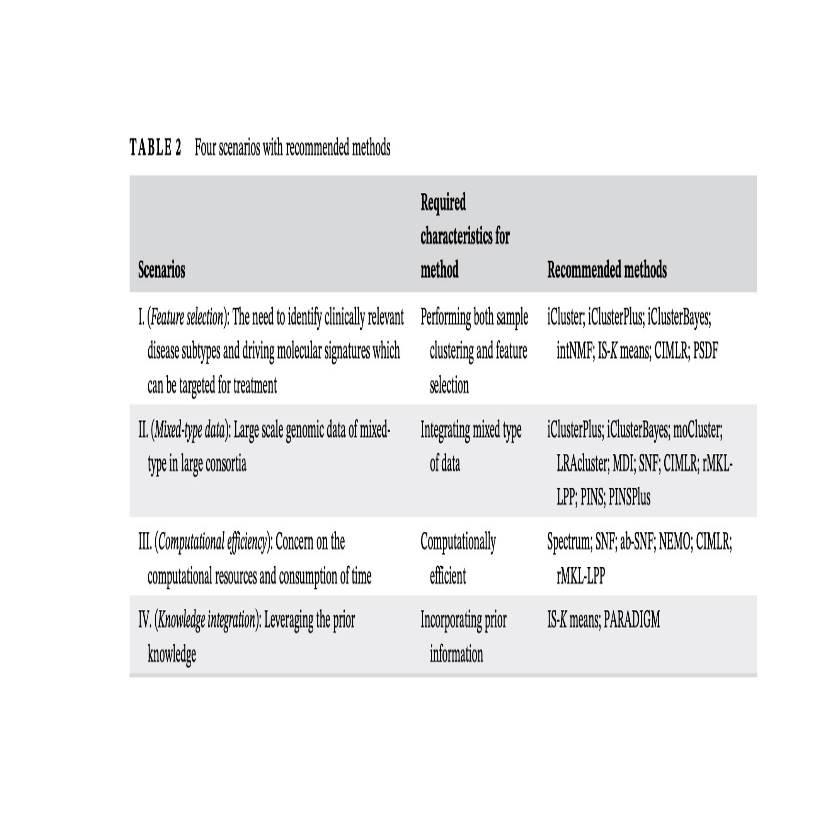

In [3]:
jj <- readJPEG("methods_comparison.jpeg",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)


# Data

We'll be using mRNA expression, microRNA (miRNA), and DNA methylation data from 343 subjects with breast cancer (from TCGA's BRCA data). The omics data was originally provided with the R package **r.jive** which had already completed the initial pre-processing steps of each data type. The clinical data was sourced from TCGAbiolinks. For the Rdata file you've found on the Github, I also did some formatting of the data to streamline analyses in this lab.  I matched all dataset by subject and formatted clinical data to factors when needed. I then save the data as an Rdata file as a list the following structure:

```
brca_dat <- list("clinical" = dataClin,
								 "MO" = list(
								 "Expression" = exp_matched,
								 "Methylation" = methyl_matched,
								 "miRNA" = miRna_matched
								 ))
```

It's essentially a list with a dataframe for clinical data under "clinical", and then a list ("MO") of the 3 omics types ("Expression" for mRNA expression, "Methylation" for DNA methylation, and "miRNA" for the microRNA expression).

**NOTE: It is very imporant that all data is matched by sample!**

We'll be using the same omics data from r.jive in our third lab so you can get a sense of how the various approaches might compare.

The data were originally referenced in this article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3465532/#!po=47.7273

The following arrays were used:

* mRNA Gene Expression Profiling: Agilent custom 244K whole genome microarrays
* Array-based DNA methylation assay: Illumina Infinium DNA methylation platforms, HumanMethylation27 (HM27) BeadChip and HumanMethylation450 (HM450) BeadChip (Illumina, San Diego, CA)

The microRNA was sequenced.

## Pre-processing Steps

The following pre-processing steps were performed, as detailed by: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3789539/#sec-10title

RNA Expression:

* Missing mRNA expression values were imputed with k-nearest-neighbors
* Select the most variable genes: those with a standard deviation > 1.5

miRNA Expression:

* miRNAs with more than 50% missing values were removed
* log-transform the data (log(1 + miRNA))

We have a total of 343 subjects, 645 mRNA transcripts, 574 CpG sites (methylation), 423 miRNA transcripts.

# Goal

Our goal with this analysis will be subtype the subjects by omics profiles, then test those identified subtypes with outcomes or other clinical traits. We'll also explore differences in the subtypes' omics profiles with differential expression and gene set enrichment.


In [4]:
# install.packages("Rfssa") if you want to download through github
library(Rfssa)
url <- "https://github.com/KechrisLab/ASAShortCourse-MultiOmics/blob/main/Lecture%202/brca_dat.Rdata"
load_github_data(url)

# load("brca_dat.Rdata")

Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [5]:
# let's get a quick look at our data
names(brca_dat)
paste("dim of clinical data:", dim(brca_dat[["clinical"]]))
head(brca_dat[["clinical"]])

# check sample names all match
identical(brca_dat[["clinical"]]$bcr_patient_barcode, colnames(brca_dat[["MO"]][["Expression"]]))
identical(brca_dat[["clinical"]]$bcr_patient_barcode, colnames(brca_dat[["MO"]][["Methylation"]]))
identical(brca_dat[["clinical"]]$bcr_patient_barcode, colnames(brca_dat[["MO"]][["miRNA"]]))
                                                                                
identical(colnames(brca_dat[["MO"]][["Expression"]]), colnames(brca_dat[["MO"]][["Methylation"]]))
identical(colnames(brca_dat[["MO"]][["Expression"]]), colnames(brca_dat[["MO"]][["miRNA"]]))
identical(colnames(brca_dat[["MO"]][["Methylation"]]), colnames(brca_dat[["MO"]][["miRNA"]]))
# should all be TRUE (6)

[1] "clinical" "MO"

[1] "dim of clinical data: 343" "dim of clinical data: 14"

bcr_patient_barcode age_at_diagnosis ajcc_pathologic_stage
TCGA-A1-A0SH TCGA-A1-A0SH        14595            Stage IIA            
TCGA-A1-A0SJ TCGA-A1-A0SJ        14383            Stage IIIA           
TCGA-A1-A0SK TCGA-A1-A0SK        20048            Stage IIA            
TCGA-A1-A0SO TCGA-A1-A0SO        24826            Stage IIB            
TCGA-A2-A04N TCGA-A2-A04N        24155            Stage IA             
TCGA-A2-A04P TCGA-A2-A04P        13238            Stage IIIC           
             ajcc_pathologic_t ajcc_pathologic_n ajcc_pathologic_m vital_status
TCGA-A1-A0SH T2                N0 (i-)           M0                Alive       
TCGA-A1-A0SJ T3                N1a               M0                Alive       
TCGA-A1-A0SK T2                N0 (i-)           M0                Dead        
TCGA-A1-A0SO T2                N1                M0                Alive       
TCGA-A2-A04N T1c               N0 (i-)           M0                Alive       
TCGA-A2-A04P T2                N3c               M0                Dead        
             days_to_death days_to_last_followup pathologic_stage
TCGA-A1-A0SH NA            1437                  Stage_II        
TCGA-A1-A0SJ NA            416                   Stage_III       
TCGA-A1-A0SK 967           NA                    Stage_II        
TCGA-A1-A0SO NA            852                   Stage_II        
TCGA-A2-A04N NA            4354                  Stage_I         
TCGA-A2-A04P 548           NA                    Stage_III       
             BRCA_Pathology BRCA_Subtype_PAM50 fustat futime
TCGA-A1-A0SH Mixed          LumA               0      1437  
TCGA-A1-A0SJ IDC            LumA               0       416  
TCGA-A1-A0SK Other          Basal              1       967  
TCGA-A1-A0SO NA             Basal              0       852  
TCGA-A2-A04N Other          LumA               0      4354  
TCGA-A2-A04P IDC            Basal              1       548

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [6]:
paste("names of MO data:", names(brca_dat[["MO"]]))
paste("dim of mRNA data:", dim(brca_dat[["MO"]][["Expression"]]))
paste("dim of methylation data:", dim(brca_dat[["MO"]][["Methylation"]]))
paste("dim of miRNA data:", dim(brca_dat[["MO"]][["miRNA"]]))

[1] "names of MO data: Expression"  "names of MO data: Methylation"
[3] "names of MO data: miRNA"

[1] "dim of mRNA data: 645" "dim of mRNA data: 343"

[1] "dim of methylation data: 574" "dim of methylation data: 343"

[1] "dim of miRNA data: 423" "dim of miRNA data: 343"

Let's make sure there are no missing values:

In [7]:
# data checking -- are there any missing values?
sum(is.na(brca_dat[["MO"]][["Expression"]]))
sum(is.na(brca_dat[["MO"]][["Methylation"]]))
sum(is.na(brca_dat[["MO"]][["miRNA"]]))

[1] 0

[1] 0

[1] 0

Let's also have a quick look at the distributions:

[1] -10.16825  12.16313

[1] 0.08450738 0.99379288

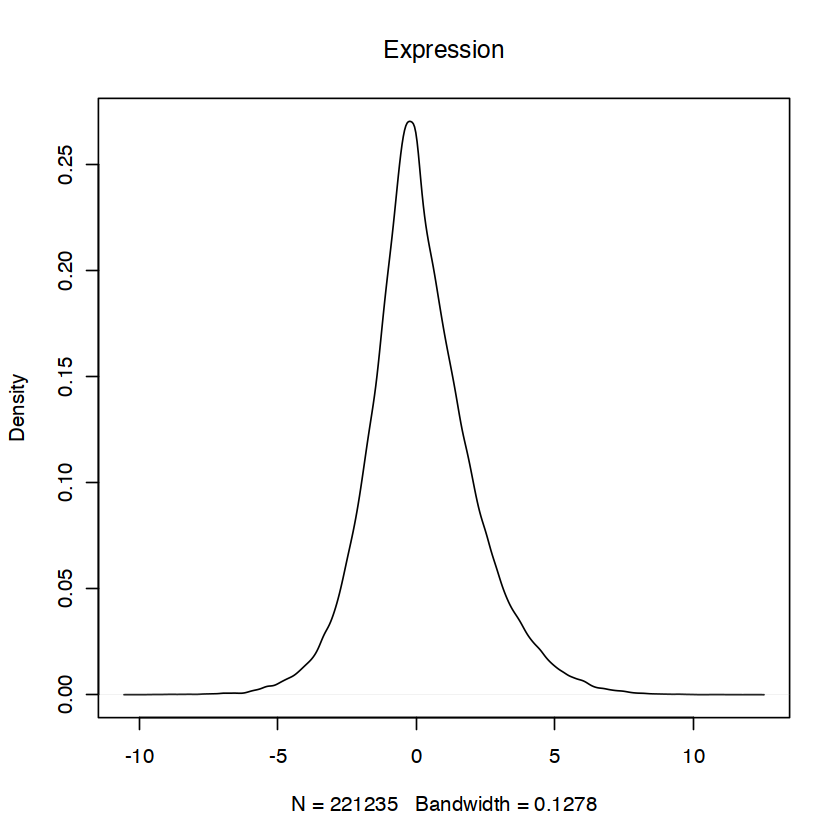

[1]  0.00000 13.32126

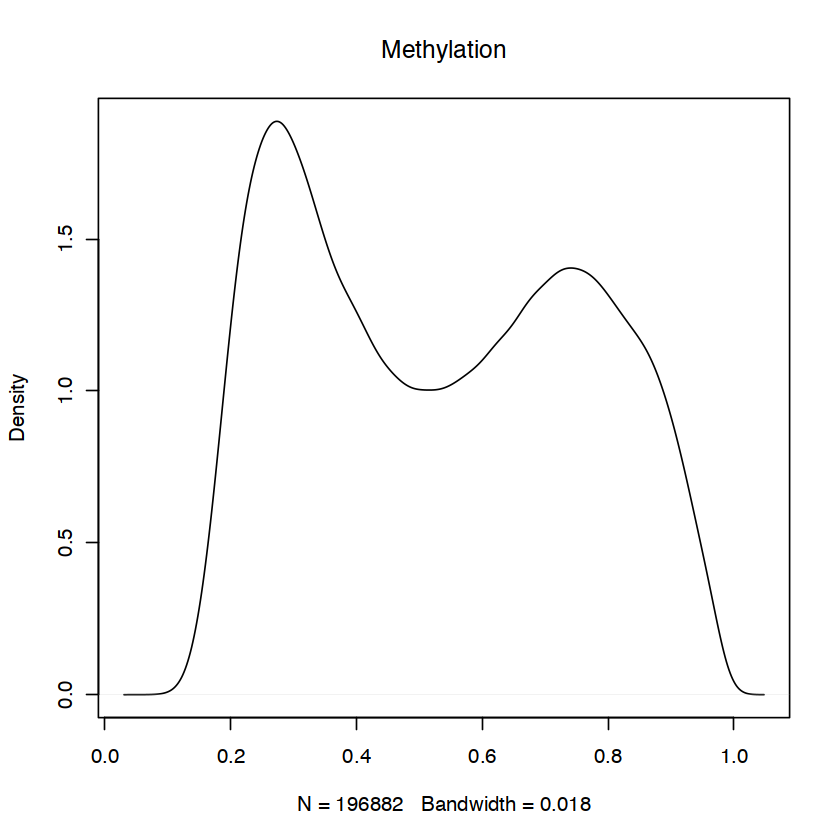

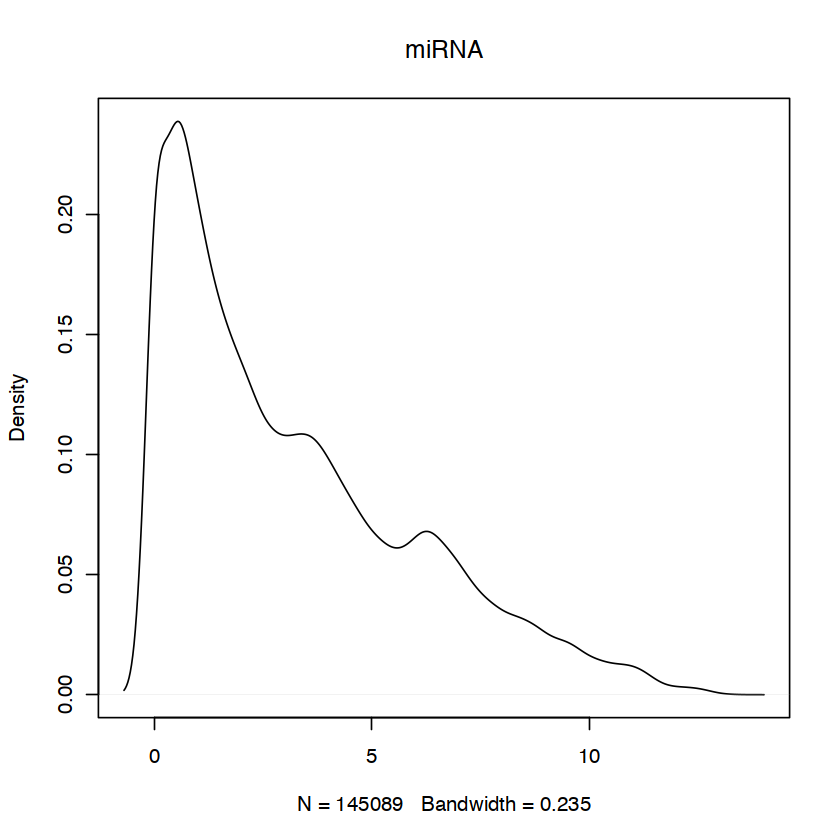

In [8]:
# exp
range(brca_dat[["MO"]][["Expression"]])
plot(density(brca_dat[["MO"]][["Expression"]]), main = "Expression")

# methyl
range(brca_dat[["MO"]][["Methylation"]])
plot(density(brca_dat[["MO"]][["Methylation"]]), main = "Methylation")

# miRNA
range(brca_dat[["MO"]][["miRNA"]])
plot(density(brca_dat[["MO"]][["miRNA"]]), main = "miRNA")


# Identifying Variable Features

With omics data, it is important to filter to the most variable features. This will reduce the dimensions as well as focus our analysis to only "important" features or adequately strong signals. The data we're working with has already done this, but here's a brief look at how it could be done with MOVICS using the *getElites()* function.

```
elite.tmp <- getElites(dat       = single_MO_dataset,
                       method    = "mad", (see below for further options)
                       na.action = "impute", # NA values will be imputed
                       elite.pct = 0.1) # keep only top 10% features with high mad values
```

This function provides the following methods to identify the most variable features:

* "mad" - median absolute deviation (default)
* "sd" - standard deviation
* "pca" - principle componenets analysis
* "cox" - univariate Cox proportional hazards regression
* "freq" - frequency, for binary omics data

It allows for imputation of missing values using k-nearest-neighbors. Note that the default is to remove missing values.

Additionally, there are parameters to log2-transform, center, and scale the data prior to filtering. And of course refer to the documentation for additional options.

# Identifying Optimal Clusters *k*

One of the key parameters an analyst sets for unsupervised clustering is the number of clusters to use, *k*. 

MOVICS provides the function *getClustNum()* to calculate the Cluster Prediction Index (CPI; Chalise 2017) and Gap Statististc (Tibshirani 2001). The function will estimate the number of clusters to maximize both of these values.

However, it is important to look at the plot holistically. If biological knowledge highly suggests a certain number of clusters have been noted in a disease, and the CPI and Gap statistic at that number are still quite high, it might make sense to use that number of clusters versus the one algortihmically defined here. The original paper associated with the BRCA data identified 4 subtypes, and a commonly used classifier, PAM50 (based on 50 genes) also has 4 subtypes. (See figure below; from https://doi.org/10.1016/B978-0-12-800886-7.00021-2) The results of *getClustNum* suggested 3 subtypes here, but given this biological knowledge and small differences in the CPI and gap statistic if we increase to k=4, I selected 4 subtypes. Furthermore, Silhoutte scores (below) suggested better clustering with 4 groups.

Summary of Statistics:

* CPI: a resampling method using *intNMF*. It repeatedly partitions the data into training and testing sets. "Observed" clusters are the clustering assignments from running *intNMF* on the testing set directly; "Predicted" clusters are those predicted for the test data using *intNMF* on the training data to build a model. The degree of consensus/agreement is calculated with an adjusted rand index. CPI is the average of the adjusted rand indices after repeating several times.

* Gap Statistic: "compares change of within-cluster dispersion with that expected under appropriate reference null distribution"


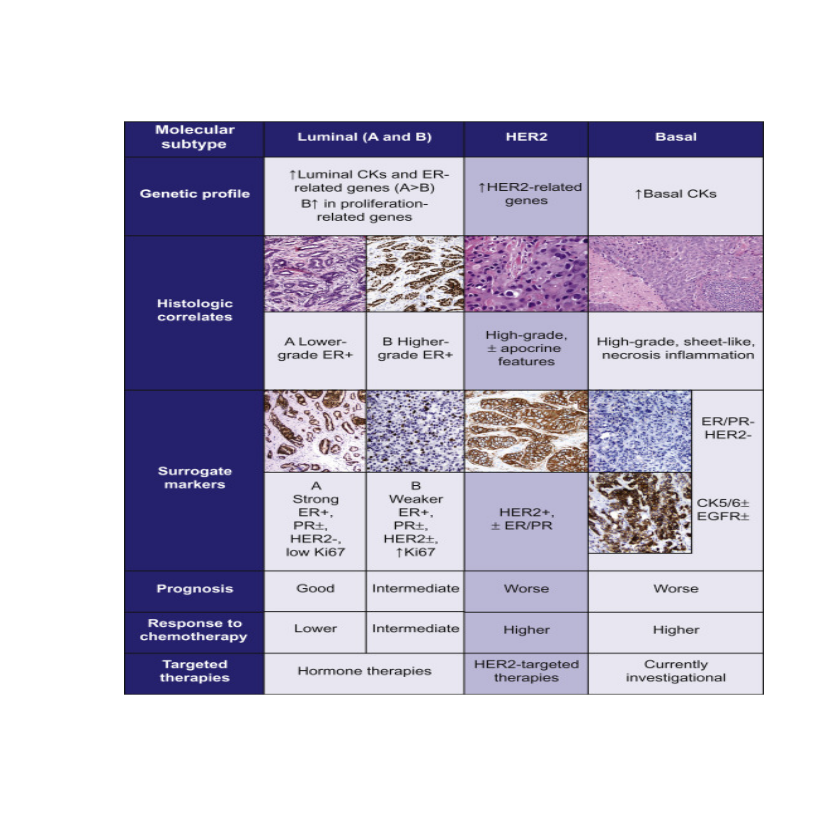

In [9]:
jj <- readJPEG("ex_breastcancer_pic.jpeg")
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)
# https://doi.org/10.1016/B978-0-12-800886-7.00021-2

calculating Cluster Prediction Index...

5% complete

5% complete

10% complete

10% complete

15% complete

15% complete

20% complete

25% complete

25% complete

30% complete

30% complete

35% complete

35% complete

40% complete

45% complete

45% complete

50% complete

50% complete

55% complete

55% complete

60% complete

65% complete

65% complete

70% complete

70% complete

75% complete

75% complete

80% complete

85% complete

85% complete

90% complete

90% complete

95% complete

95% complete

100% complete

calculating Gap-statistics...

visualization done...

--the imputed optimal cluster number is 3 arbitrarily, but it would be better referring to other priori knowledge.



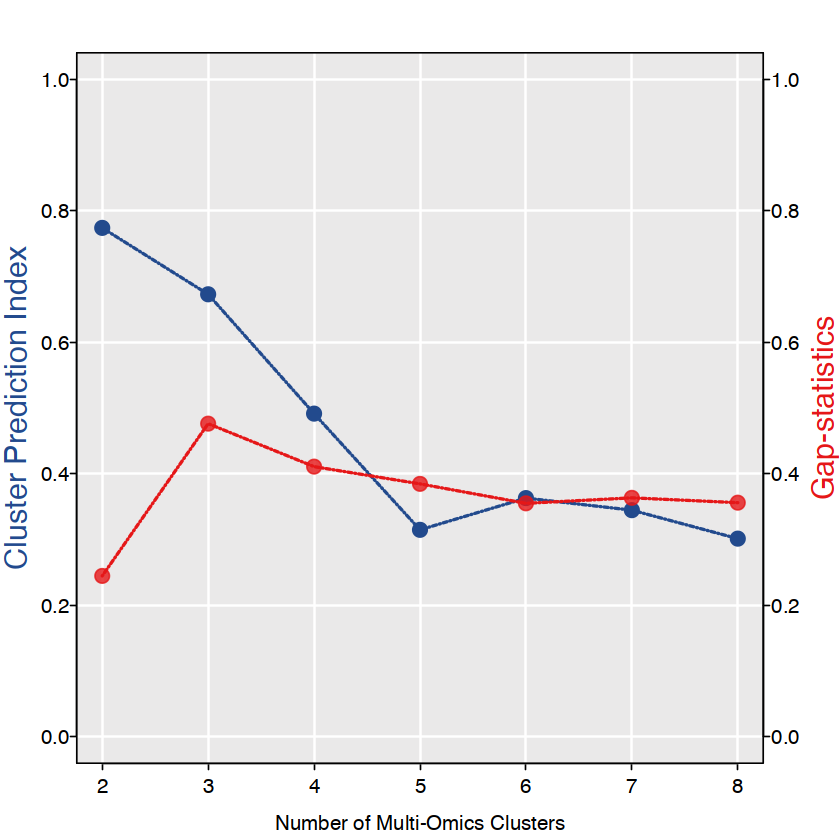

In [10]:
optk.brca <- getClustNum(data        = brca_dat[["MO"]],
                         is.binary   = c(F,F,F), # all omics data is continuous (not binary)
                         try.N.clust = 2:8, # try cluster number from 2 to 8
                         fig.name    = "CLUSTER NUMBER OF TCGA-BRCA")



In [12]:
optk.brca

$N.clust
[1] 3

$CPI
        run1      run2      run3      run4      run5
k2 0.8432502 0.7282426 0.7316823 0.7425548 0.8233950
k3 0.6059018 0.7734596 0.6479677 0.8111728 0.5258236
k4 0.4500327 0.5359211 0.4930524 0.5138497 0.4643814
k5 0.3129734 0.2815951 0.3444218 0.3395948 0.2953664
k6 0.2948730 0.3657889 0.3485947 0.4040925 0.4018108
k7 0.3452716 0.3447002 0.3492336 0.3091536 0.3750556
k8 0.2977934 0.3017578 0.3338568 0.2933031 0.2802605

$Gapk
      logW   E.logW       gap     SE.sim
2 7.341067 7.585790 0.2447224 0.02841250
3 6.931700 7.407904 0.4762041 0.03260670
4 6.823207 7.234078 0.4108715 0.03826871
5 6.733596 7.118257 0.3846612 0.03225452
6 6.662954 7.018019 0.3550653 0.03089040
7 6.571253 6.934678 0.3634251 0.02677588
8 6.509093 6.865159 0.3560663 0.02663530

--you choose more than 1 algorithm and all of them shall be run with parameters by default.

SNF done...

Clustering method: kmeans

Perturbation method: noise

PINSPlus done...

NEMO done...

LRAcluster done...

IntNMF done...



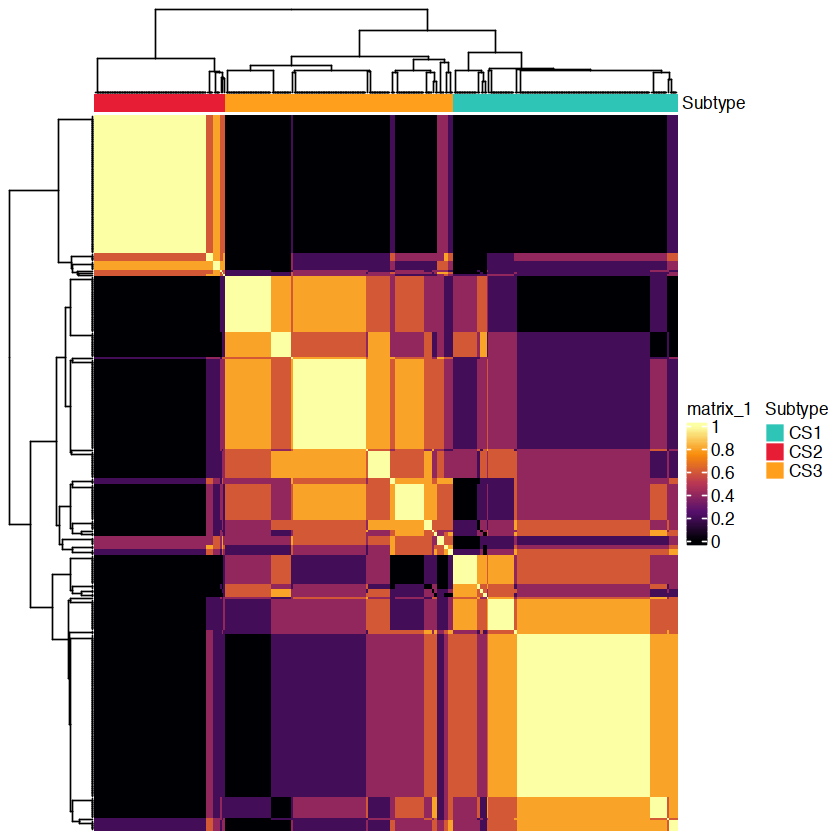

pdf 
  2

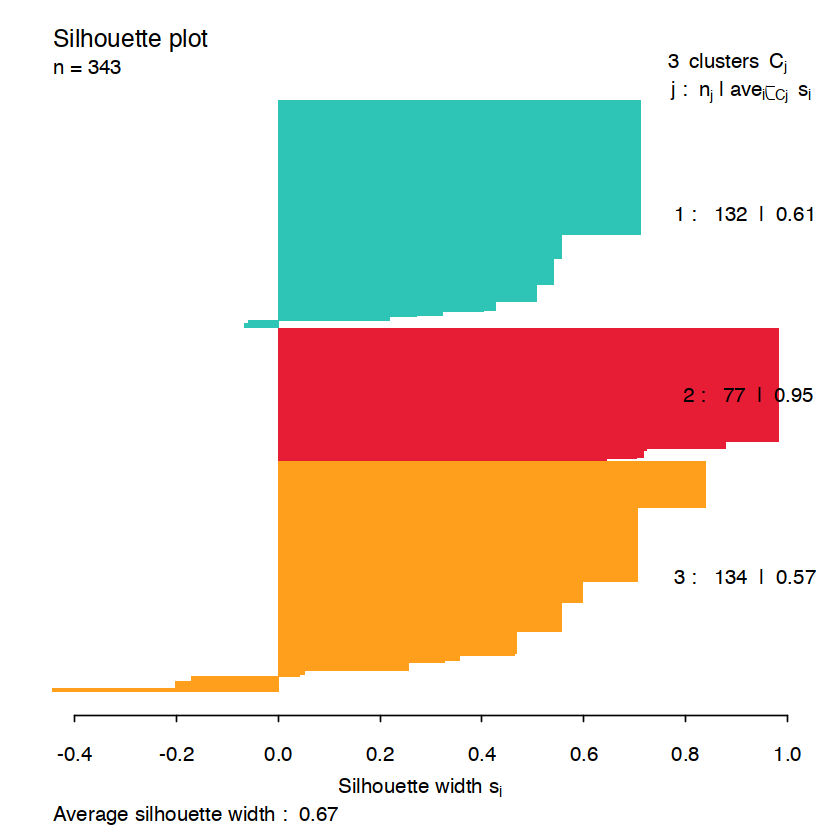

In [13]:
# what if we use the suggested k=3 clusters?
# you don't need to run this during lab; I'm just presenting it as an example
mo_rslts_3 <- getMOIC(data = brca_dat[["MO"]],
                         methodslist = list("SNF", "PINSPlus", "NEMO", "LRAcluster", "IntNMF"),
                         N.clust     = 3,
                         type        = c("gaussian", "gaussian", "gaussian"))

cmoic.brca_3 <- getConsensusMOIC(moic.res.list = mo_rslts_3,
                               fig.name      = "CONSENSUS HEATMAP - 3 Clusters",
                               distance      = "euclidean",
                               linkage       = "average")

getSilhouette(sil      = cmoic.brca_3$sil, # a sil object returned by getConsensusMOIC()
              fig.path = getwd(),
              fig.name = "SILHOUETTE",
              height   = 5.5,
              width    = 5)

# Perform Unsupervised Clustering

We will now use the main workhorse of MOVICS to perform unsupervised clustering of our omics data, using SNF as well as NEMO, IntNMF, LRAcluster, and PINSPlus. The package contains other methods as well, but we have selected just a few to limit computational burdens during this lab. I would suggest playing around with them on your own following our session.

We will focus on the results of SNF and compare them to the larger consensus clustering using SNF and the 4 other methods.

Note that if you want to specify specific parameters for a method, you can use the function "get"(method name) (e.g. getSNF()), then compile the results into a list.

In [14]:
mo_rslts <- getMOIC(data = brca_dat[["MO"]],
                         methodslist = list("SNF", "PINSPlus", "NEMO", "LRAcluster", "IntNMF"),
                         N.clust     = 4, # set number of clusters
                         type        = c("gaussian", "gaussian", "gaussian")) # what is the distribution of the datasets in MO list (same order)


--you choose more than 1 algorithm and all of them shall be run with parameters by default.

SNF done...

Clustering method: kmeans

Perturbation method: noise

PINSPlus done...

NEMO done...

LRAcluster done...

IntNMF done...



# Get Consensus of Clustering Methods

We'll now use the function *getConsensusMOIC* to build a consensus matrix from our clustering results from the 4 methods. 

The package developers built this function with the idea of consensus ensembles in mind to generate a consensus matrix of our clustering methods. This will improve our robustness. The idea is to calculate a matrix $M^{(t)}_{nxn}$ per each algorithm. $M^{(t)}_{ij} = 1$ when samples $i$ and $j$ are in the same subtype, otherwise $M^{(t)}_{ij} = 0$. The consensus matrix is then: $CM = \sum_{t=1}^{t_{max}}{M^{(t)}}$.

This matrix "represents robust pairwise similarities for the samples because it considers different multi-omics integrative clustering algorithms. MOVICS then searches for a stable clustering result by applying hierarchical clustering to $CM$.

$CM$ a probability matrix that represents how many times samples belonging to the same subtype can be clustered together by different multi-omics clustering methods. Ideally, the consensus heatmap will show a perfect diagonal rectangle, and the input values are 0 and 1 only because all algorithms derived the same clustering results."

The function will provide the following:

* consensus.hm: an object returned by pheatmap

* similarity: a similary matrix for pair-wise samples with entries ranging from 0 to 1

* sil: a silhouette object that can be further passed to getSilhouette

* clust.res: a data.frame storing sample ID and corresponding clusters

* clust.dend: a dendrogram of sample clustering

* mo.method: a string value indicating the method used for multi-omics integrative clustering

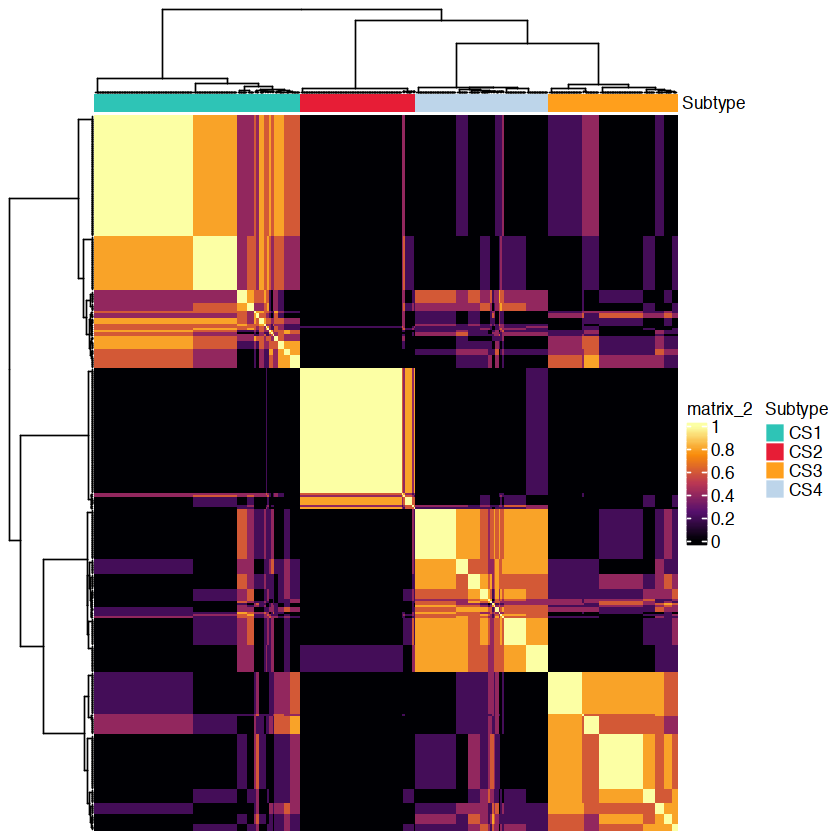

In [15]:
cmoic.brca <- getConsensusMOIC(moic.res.list = mo_rslts,
                               fig.name      = "CONSENSUS HEATMAP - 4 Clusters",
                               distance      = "euclidean",
                               linkage       = "ward.D")

We can also quantify and visualize the sample similarity more specifically given the identified clusters using Silhouette scores.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. (https://en.wikipedia.org/wiki/Silhouette_(clustering))

pdf 
  2

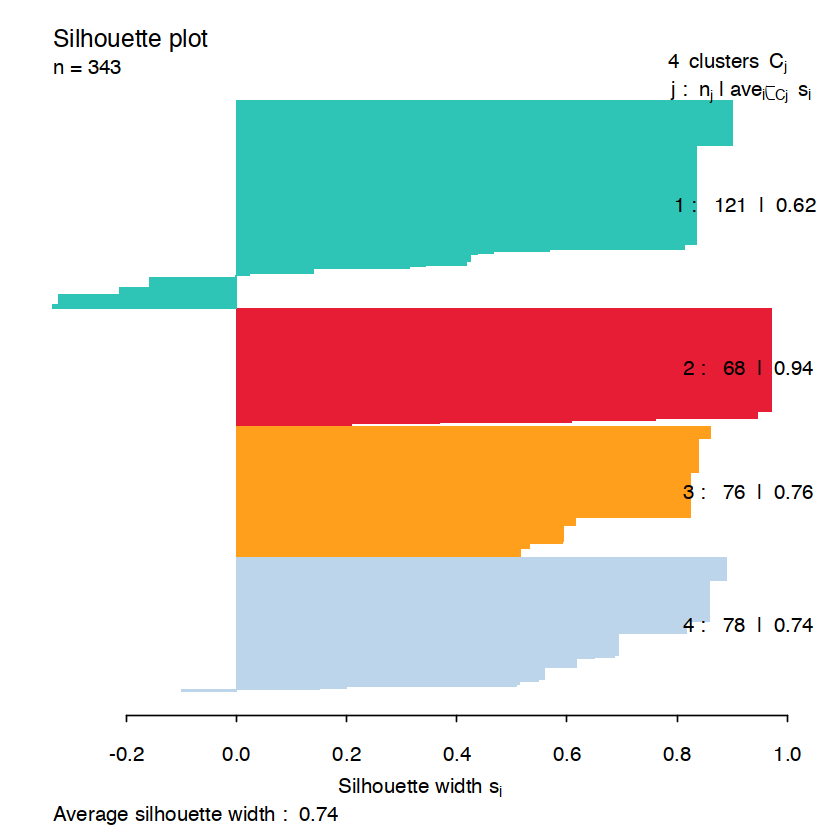

In [16]:
getSilhouette(sil      = cmoic.brca$sil, # a sil object returned by getConsensusMOIC()
              fig.path = getwd(),
              fig.name = "SILHOUETTE",
              height   = 5.5,
              width    = 5)

# Multi-Omics Heatmap

We can get a good visualization of our data by building a genome-wide heatmap. This can provide insight on how the samples and genes cluster together or potential sample biases or other artifacts.

We must first make sure our data are appropriately processed for visualization. For continuous data, particularly expression data (e.g., RNA and protein), we should center (centerFlag = TRUE), scale (scaleFlag = TRUE), or z-score (both centered and scaled). DNA methyatlion data is usually measured in terms of $\beta$-values, which describe the percent methylation at that probe and is bimodally distributed (see above). Therefore, we convert the $\beta$-values to M-values using the formula: $M = log_{2} \frac{{\beta}}{({1-\beta})}$. This leads to a stronger signal in visualization and we can normalize these M-values.

This function also provides an argument of halfwidth for continuous omics data; this is used to truncate the ‘extremum’ after normalization; specifically, normalized values that exceed the halfwidth boundaries will be replaced by the halfwidth, which is beneficial to map colors in heatmap.

I've also added annotations for the PAM50 subtypes to help compare our findings with previous knowledge.

In [17]:
# convert beta value to M value for stronger signal
std_dat <- brca_dat[["MO"]]
std_dat[["Methylation"]] <- log2(std_dat[["Methylation"]] / (1 - std_dat[["Methylation"]]))

# data normalization for heatmap
plotdata <- getStdiz(data       = std_dat,
                     halfwidth  = c(2,2,2), # no truncation for mutation
                     centerFlag = c(T,T,T), # no center for mutation
                     scaleFlag  = c(T,T,T)) # no scale for mutation

mRNA.col   <- c("#00FF00", "#008000", "#000000", "#800000", "#FF0000")
meth.col   <- c("#0074FE", "#96EBF9", "#FEE900", "#F00003")
miRNA.col <- c("#6699CC", "white"  , "#FF3C38")
col.list   <- list(mRNA.col, meth.col, miRNA.col)

# extract PAM50, pathologic stage for sample annotation
annCol    <- brca_dat[["clinical"]][,c("BRCA_Subtype_PAM50"), drop = FALSE]

# generate corresponding colors for sample annotation
annColors <- list(
                  BRCA_Subtype_PAM50  = c("Basal" = "blue",
                            "Her2"   = "red",
                            "LumA"   = "yellow",
                            "LumB"   = "green",
                            "Normal" = "black")
                )



## SNF

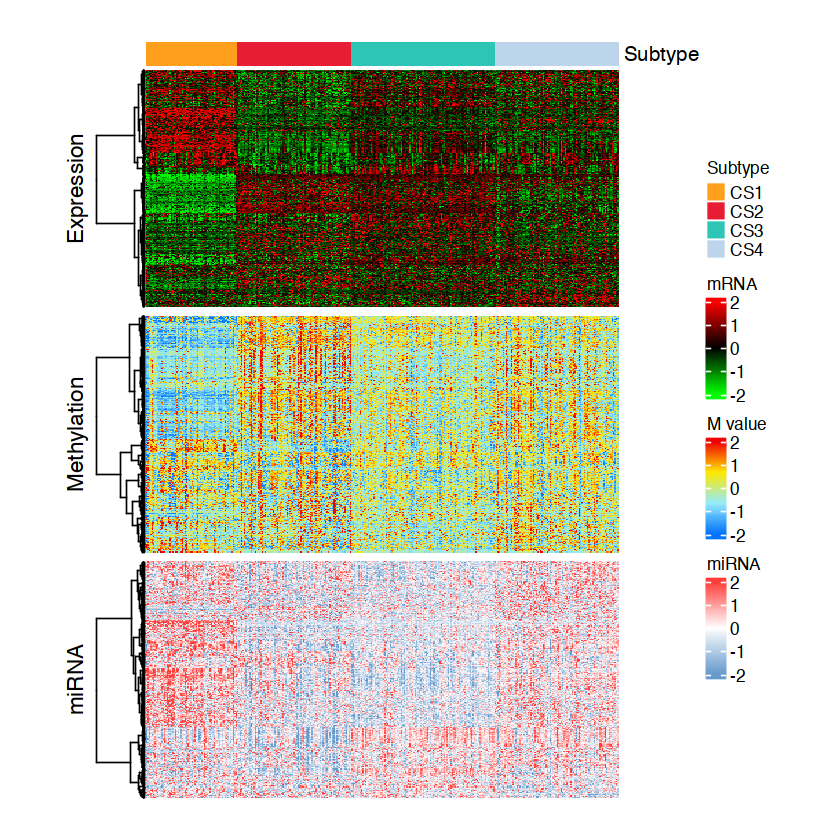

In [18]:
# comprehensive heatmap
getMoHeatmap(data          = plotdata,
             row.title     = names(std_dat),
             is.binary     = c(F,F,F), # we don't have any binary omics data (ex mutation)
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = mo_rslts$SNF$clust.res, # cluster results for SNF
             color         = col.list,
             # annCol        = annCol, # annotation for samples (if you want to show PAM50 classes too)
             # annColors     = annColors, # annotation color
             width         = 10, # width of each subheatmap
             height        = 5, # height of each subheatmap
             fig.name      = "COMPREHENSIVE HEATMAP OF SNF")

## PINSPlus

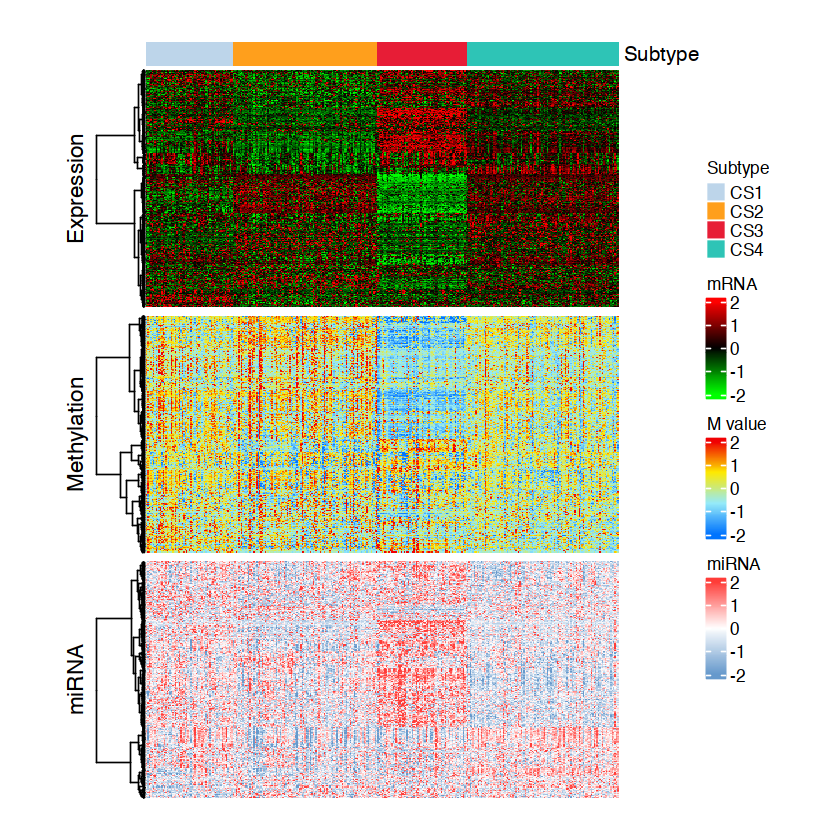

In [19]:
getMoHeatmap(data          = plotdata,
             row.title     = names(std_dat),
             is.binary     = c(F,F,F), # all data is continuous
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = mo_rslts$PINSPlus$clust.res, # cluster results for PINSPlus
             color         = col.list,
             width         = 10, # width of each subheatmap
             height        = 5, # height of each subheatmap
             fig.name      = "COMPREHENSIVE HEATMAP OF PINSPlus")

## NEMO

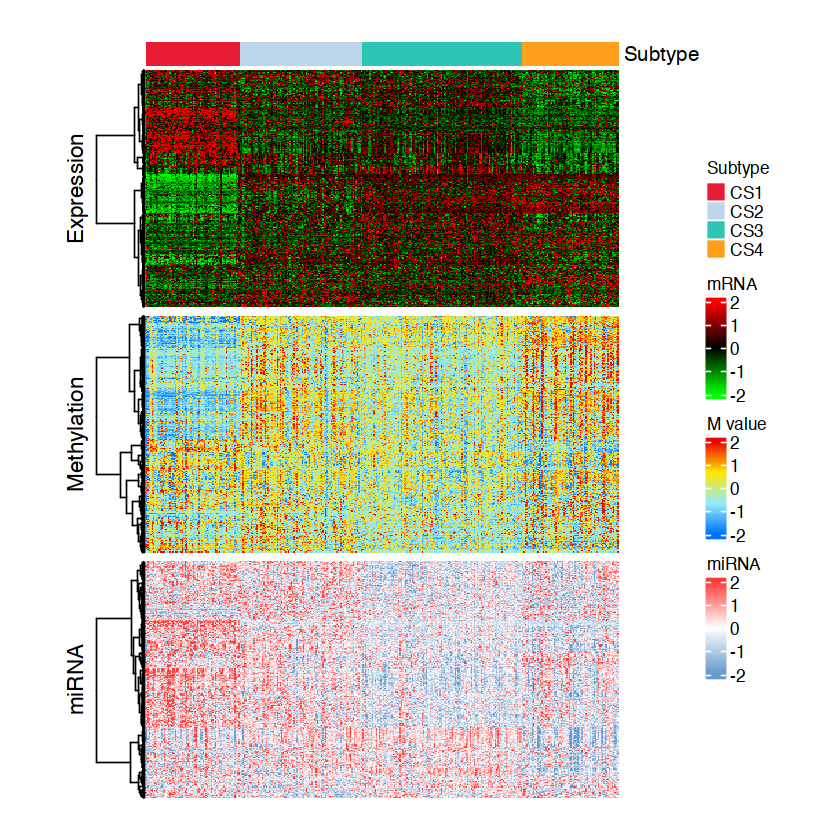

In [20]:
# comprehensive heatmap (may take a while)
getMoHeatmap(data          = plotdata,
             row.title     = names(std_dat),
             is.binary     = c(F,F,F),
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = mo_rslts$NEMO$clust.res, # cluster results for NEMO
             color         = col.list,
             width         = 10, # width of each subheatmap
             height        = 5, # height of each subheatmap
             fig.name      = "COMPREHENSIVE HEATMAP OF PINSPlus")

## LRAcluster

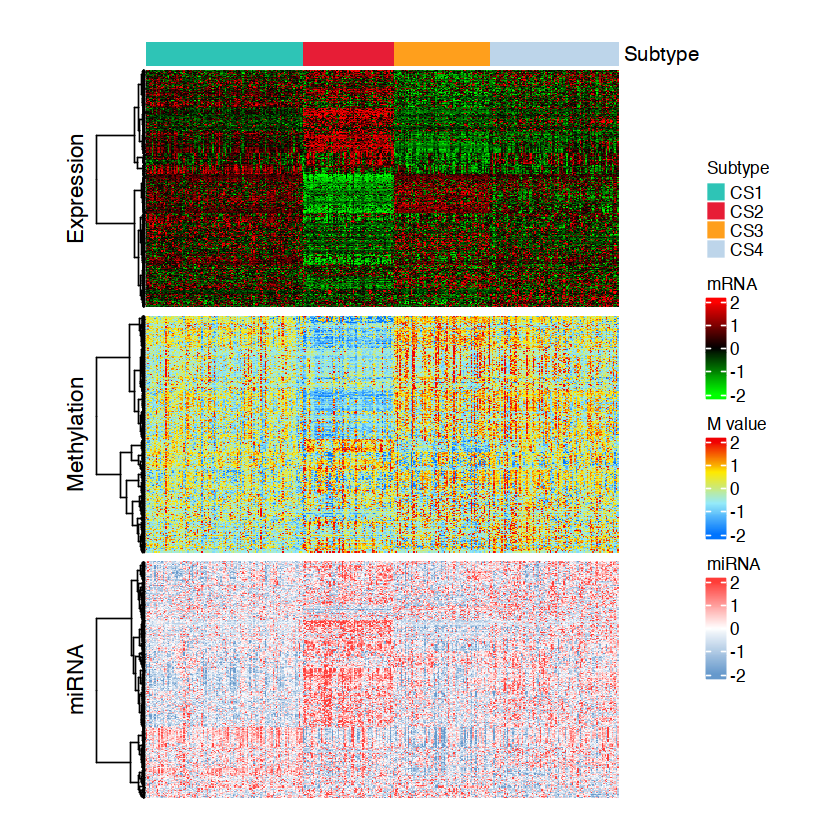

In [21]:
# comprehensive heatmap (may take a while)
getMoHeatmap(data          = plotdata,
             row.title     = names(std_dat),
             is.binary     = c(F,F,F),
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = mo_rslts$LRAcluster$clust.res, # cluster results for LRAcluster
             color         = col.list,
             width         = 10, 
             height        = 5, 
             fig.name      = "COMPREHENSIVE HEATMAP OF PINSPlus")

## IntNMF

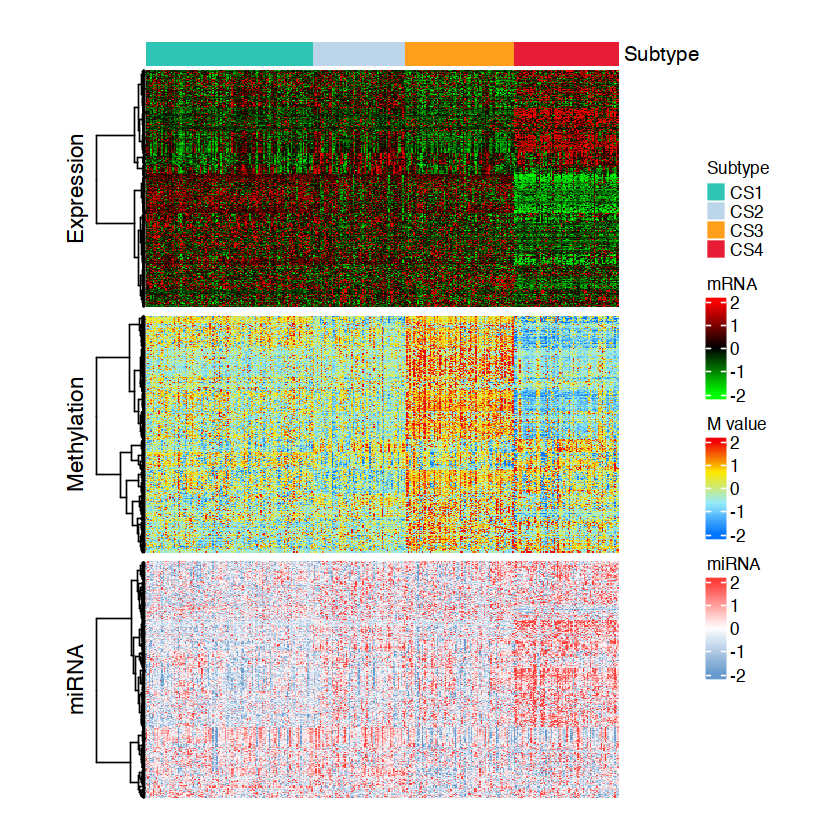

In [22]:
# comprehensive heatmap (may take a while)
getMoHeatmap(data          = plotdata,
             row.title     = names(std_dat),
             is.binary     = c(F,F,F),
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = mo_rslts$IntNMF$clust.res, # cluster results for intNMF
             color         = col.list,
             width         = 10, # width of each subheatmap
             height        = 5, # height of each subheatmap
             fig.name      = "COMPREHENSIVE HEATMAP OF IntNMF")

## Consensus Matrix

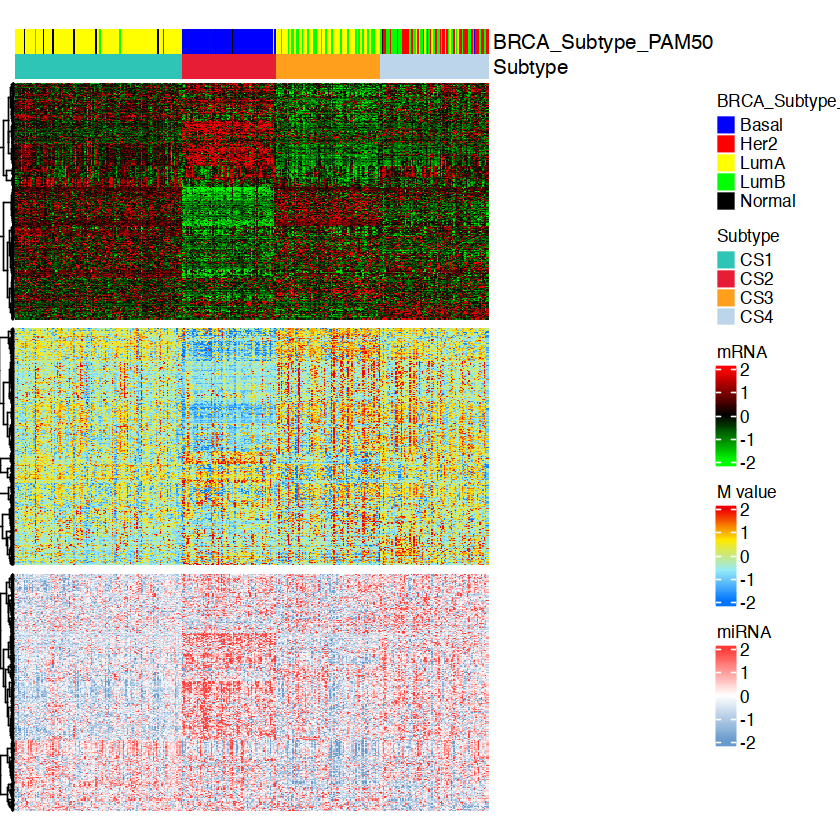

In [23]:
getMoHeatmap(data          = plotdata,
             row.title     = names(plotdata),
             is.binary     = c(F,F,F), # no binary omics data
             legend.name   = c("mRNA","M value","miRNA"),
             clust.res     = cmoic.brca$clust.res, # consensusMOIC results
             clust.dend    = NULL, # show no dendrogram for samples
             show.colnames = FALSE, # show no sample names
             show.row.dend = c(T,T,T), # show dendrogram for features
             annRow        = NULL, # no selected features
             color         = col.list,
             annCol        = annCol, # annotation for samples
             annColors     = annColors, # annotation color
             width         = 10, # width of each subheatmap
             height        = 5, # height of each subheatmap
             fig.name      = "COMPREHENSIVE HEATMAP OF CONSENSUSMOIC")

In [24]:
clust_rslts_SNF_df <- data.frame(mo_rslts$SNF$clust.res)
colnames(clust_rslts_SNF_df) <- c("samID", "SNF")
clust_rslts_CM_df <- data.frame(cmoic.brca$clust.res)
colnames(clust_rslts_CM_df) <- c("samID", "Consensus")

clust_rslts_df <- merge(clust_rslts_SNF_df, clust_rslts_CM_df, by="samID")
# head(clust_rslts_df)

table(clust_rslts_df$SNF, clust_rslts_df$Consensus)

   
      1   2   3   4
  1   0  66   0   0
  2   5   0  76   2
  3 104   0   0   0
  4  12   2   0  76

# How are our clusters different?: the COMP Module

Now we will explore how the clusters or subtypes we've identified differ with regard to patient characteristics. We'll explore survival outcomes, compare clinical features, and agreement with the PAM50 subtype.


## Survival Outcomes

We'll start with using the *compSurv()* function to compare survival among our identified subtypes. This function will calculate the overall nominal P value by log-rank test, perform pairwise comparisons with adjusted p-values with BH, and provide a Kaplan-Meier Curve for visulaization.

We must also provide data frame that includes the subejcts' survival data (surv.info argument). Again, rownames must match our previous data. It must also have a column **futime** for survival time (in days) and another column **fustat** for survival outcome (0 = censor; 1 = event).

The result will provide the following:

* A figure of multi-omics Kaplan-Meier curve (.pdf) and a list with the following components:

* fitd: an object returned by survdiff.

* fid: an object returned by survfit.

* xyrs.est: x-year probability of survival and the associated lower and upper bounds of the 95

* overall.p: a nominal p.value calculated by Kaplain-Meier estimator with log-rank test

* pairwise.p: an object of class "pairwise.htest" which is a list containing the p values (see pairwise_survdiff); (only returned when more than 2 subtypes are identified).


bcr_patient_barcode age_at_diagnosis ajcc_pathologic_stage
TCGA-A1-A0SH TCGA-A1-A0SH        14595            Stage IIA            
TCGA-A1-A0SJ TCGA-A1-A0SJ        14383            Stage IIIA           
TCGA-A1-A0SK TCGA-A1-A0SK        20048            Stage IIA            
TCGA-A1-A0SO TCGA-A1-A0SO        24826            Stage IIB            
TCGA-A2-A04N TCGA-A2-A04N        24155            Stage IA             
TCGA-A2-A04P TCGA-A2-A04P        13238            Stage IIIC           
             ajcc_pathologic_t ajcc_pathologic_n ajcc_pathologic_m vital_status
TCGA-A1-A0SH T2                N0 (i-)           M0                Alive       
TCGA-A1-A0SJ T3                N1a               M0                Alive       
TCGA-A1-A0SK T2                N0 (i-)           M0                Dead        
TCGA-A1-A0SO T2                N1                M0                Alive       
TCGA-A2-A04N T1c               N0 (i-)           M0                Alive       
TCGA-A2-A04P T2                N3c               M0                Dead        
             days_to_death days_to_last_followup pathologic_stage
TCGA-A1-A0SH NA            1437                  Stage_II        
TCGA-A1-A0SJ NA            416                   Stage_III       
TCGA-A1-A0SK 967           NA                    Stage_II        
TCGA-A1-A0SO NA            852                   Stage_II        
TCGA-A2-A04N NA            4354                  Stage_I         
TCGA-A2-A04P 548           NA                    Stage_III       
             BRCA_Pathology BRCA_Subtype_PAM50 fustat futime
TCGA-A1-A0SH Mixed          LumA               0      1437  
TCGA-A1-A0SJ IDC            LumA               0       416  
TCGA-A1-A0SK Other          Basal              1       967  
TCGA-A1-A0SO NA             Basal              0       852  
TCGA-A2-A04N Other          LumA               0      4354  
TCGA-A2-A04P IDC            Basal              1       548

--a total of 343 samples are identified.



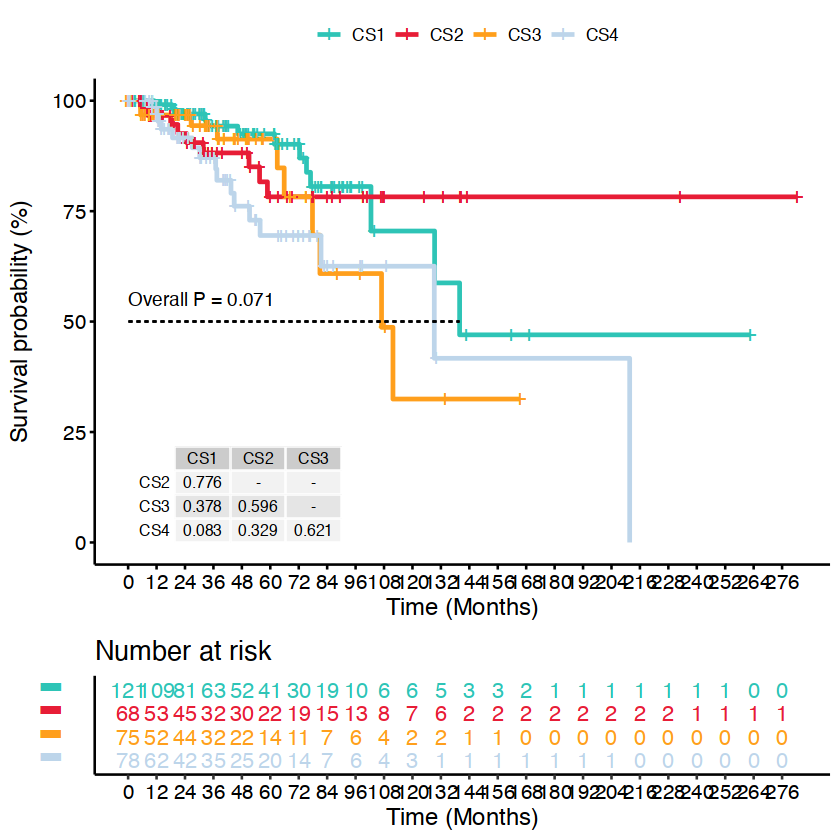

In [25]:
# survival comparison
brca_dat[["clinical"]]$futime = as.numeric(brca_dat[["clinical"]]$futime)
head(brca_dat[["clinical"]])
surv.brca <- compSurv(moic.res         = cmoic.brca,
                      surv.info        = brca_dat[["clinical"]],
                      convt.time       = "m", # convert day unit to month
                      surv.median.line = "h", # draw horizontal line at median survival
                      xyrs.est         = c(5,10), # estimate 5 and 10-year survival
                      fig.name         = "KAPLAN-MEIER CURVE OF CONSENSUSMOIC")


In [26]:
print(surv.brca)

$fitd
Call:
survdiff(formula = Surv(futime, fustat) ~ Subtype, data = mosurv.res, 
    na.action = na.exclude)

              N Observed Expected (O-E)^2/E (O-E)^2/V
Subtype=CS1 121       13    18.36     1.563     2.544
Subtype=CS2  68        9    11.86     0.691     0.942
Subtype=CS3  76       10     8.22     0.384     0.469
Subtype=CS4  78       16     9.56     4.341     5.447

 Chisq= 7  on 3 degrees of freedom, p= 0.07 

$fit
Call: survfit(formula = Surv(futime, fustat) ~ Subtype, data = mosurv.res, 
    na.action = na.exclude, error = "greenwood", type = "kaplan-meier", 
    conf.type = "plain")

      n events median 0.95LCL 0.95UCL
CS1 121     13    140   102.5      NA
CS2  68      9     NA      NA      NA
CS3  76     10    107    77.8      NA
CS4  78     16    129    81.4      NA

$xyrs.est
Call: survfit(formula = Surv(futime, fustat) ~ Subtype, data = mosurv.res)

                Subtype=CS1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
 1825     41       6 

## Compare Clinical Features

Here we'll compare pathologic stages of the cancers, defined by the American Joint Committee on Cancer (AJCC).

As summarized by Johns Hopkins:

The "pathologic stage" of a cancer takes into consideration the characteristics of the tumor ("T") and the presence of any lymph nodes metastases ("N") or distant organ metastases ("M"). These features are assigned individual scores called the pathologic T stage (T0-4), N stage (N1-3) and M stage (M0-1) are combined to form a final overall pathology stage (stage 0-IV). The pathologic stage is determined by the findings at the time of surgery and is different from the "clinical stage," which is the stage estimated based upon the findings on clinical exam and radiology. (https://pathology.jhu.edu/breast/staging-grade)


We will compare the agreement using four statistics: Rand Index (RI), Adjusted Mutual Information (AMI), Jaccard Index (JI), and Fowlkes-Mallows (FM); all these measurements range from 0 to 1 and the larger the value is, the more similar the two appraises are. This function can also generate an alluvial diagram to visualize the agreement of two appraises with the current subtypes as reference.

We use the compClinvar function which will result in a summary table comparing the subtypes from our clustering with identified variables. This resulting table can also be formatted into Word if needed with the flag doWord = TRUE.

We coded our clinical variables regarding the various stages as factors. We also tested the continuous variable of age at diagnosis (days).

In [27]:
# clinVars_df <- brca_dat[["clinical"]][,c("ajcc_pathologic_stage", "age_at_diagnosis","ajcc_pathologic_t", "ajcc_pathologic_n","ajcc_pathologic_m")]
clinVars_df <- brca_dat[["clinical"]]
rownames(clinVars_df) <- clinVars_df$bcr_patient_barcode
clinVars_df <- clinVars_df[,c( "ajcc_pathologic_stage", "ajcc_pathologic_t", "ajcc_pathologic_n", "ajcc_pathologic_m", "age_at_diagnosis")]
head(clinVars_df)


clin.brca <- compClinvar(moic.res      = cmoic.brca,
                         var2comp      = clinVars_df, # data.frame needs to summarize (must has row names of samples)
                         strata        = "Subtype", # stratifying variable (e.g., Subtype in this example)
                         # factorVars    = c("ajcc_pathologic_stage"), # features that are considered categorical variables
                         factorVars    = c("ajcc_pathologic_stage", "ajcc_pathologic_t", "ajcc_pathologic_n", "ajcc_pathologic_m"), # features that are considered categorical variables
                         nonnormalVars = "age_at_diagnosis", # feature(s) that are considered using nonparametric test
                         exactVars     = NULL, # feature(s) that are considered using exact test
                         doWord        = FALSE, # generate .docx file in local path
                         tab.name      = "SUMMARIZATION OF CLINICAL FEATURES")
clin.brca

ajcc_pathologic_stage ajcc_pathologic_t ajcc_pathologic_n
TCGA-A1-A0SH Stage IIA             T2                N0 (i-)          
TCGA-A1-A0SJ Stage IIIA            T3                N1a              
TCGA-A1-A0SK Stage IIA             T2                N0 (i-)          
TCGA-A1-A0SO Stage IIB             T2                N1               
TCGA-A2-A04N Stage IA              T1c               N0 (i-)          
TCGA-A2-A04P Stage IIIC            T2                N3c              
             ajcc_pathologic_m age_at_diagnosis
TCGA-A1-A0SH M0                14595           
TCGA-A1-A0SJ M0                14383           
TCGA-A1-A0SK M0                20048           
TCGA-A1-A0SO M0                24826           
TCGA-A2-A04N M0                24155           
TCGA-A2-A04P M0                13238

--all samples matched.

Registered S3 methods overwritten by 'proxy':
  method               from    
  print.registry_field registry
  print.registry_entry registry



$compTab
                                        level                           CS1
1                                n                                      121
2        ajcc_pathologic_stage (%)    Stage I                    15 (12.6) 
3                                    Stage IA                     9 ( 7.6) 
4                                    Stage IB                     1 ( 0.8) 
5                                   Stage IIA                    35 (29.4) 
6                                   Stage IIB                    24 (20.2) 
7                                  Stage IIIA                    24 (20.2) 
8                                  Stage IIIB                     2 ( 1.7) 
9                                  Stage IIIC                     4 ( 3.4) 
10                                   Stage IV                     3 ( 2.5) 
11                                    Stage X                     2 ( 1.7) 
12           ajcc_pathologic_t (%)         T1                     4 ( 3.3) 
13                                        T1b                     2 ( 1.7) 
14                                        T1c                    32 (26.4) 
15                                         T2                    58 (47.9) 
16                                        T2b                     0 ( 0.0) 
17                                         T3                    19 (15.7) 
18                                         T4                     1 ( 0.8) 
19                                        T4b                     5 ( 4.1) 
20                                        T4d                     0 ( 0.0) 
21                                         TX                     0 ( 0.0) 
22           ajcc_pathologic_n (%)         N0                    22 (18.2) 
23                                    N0 (i-)                    24 (19.8) 
24                                    N0 (i+)                     9 ( 7.4) 
25                                         N1                     9 ( 7.4) 
26                                        N1a                    22 (18.2) 
27                                        N1b                     1 ( 0.8) 
28                                        N1c                     1 ( 0.8) 
29                                       N1mi                     5 ( 4.1) 
30                                         N2                     9 ( 7.4) 
31                                        N2a                    10 ( 8.3) 
32                                         N3                     2 ( 1.7) 
33                                        N3a                     6 ( 5.0) 
34                                        N3c                     0 ( 0.0) 
35                                         NX                     1 ( 0.8) 
36           ajcc_pathologic_m (%)   cM0 (i+)                     1 ( 0.8) 
37                                         M0                   116 (95.9) 
38                                         M1                     3 ( 2.5) 
39                                         MX                     1 ( 0.8) 
40 age_at_diagnosis (median [IQR])            20597.50 [17642.75, 24013.25]
                             CS2                           CS3
1                             68                            76
2                      5 ( 7.5)                      9 (12.0) 
3                      6 ( 9.0)                      6 ( 8.0) 
4                      0 ( 0.0)                      0 ( 0.0) 
5                     32 (47.8)                     23 (30.7) 
6                     13 (19.4)                     20 (26.7) 
7                      5 ( 7.5)                      9 (12.0) 
8                      1 ( 1.5)                      3 ( 4.0) 
9                      3 ( 4.5)                      1 ( 1.3) 
10                     2 ( 3.0)                      1 ( 1.3) 
11                     0 ( 0.0)                      3 ( 4.0) 
12                     4 ( 5.9)                      2 ( 2.6) 
13                     0 ( 0.0)                      3 (

## Compare with PAM50 Subtypes

We can use the compAgree function to compare our identified subtypes with the traditional PAM50 classifier. This will compute the Rand Index, Jaccard Index, Fowlkes-Mallows, and Normalized Mutual Information for agreement of two partitions, and generate an alluvial diagram for visualization.

BRCA_Subtype_PAM50
TCGA-A1-A0SH LumA              
TCGA-A1-A0SJ LumA              
TCGA-A1-A0SK Basal             
TCGA-A1-A0SO Basal             
TCGA-A2-A04N LumA              
TCGA-A2-A04P Basal

--all samples matched.



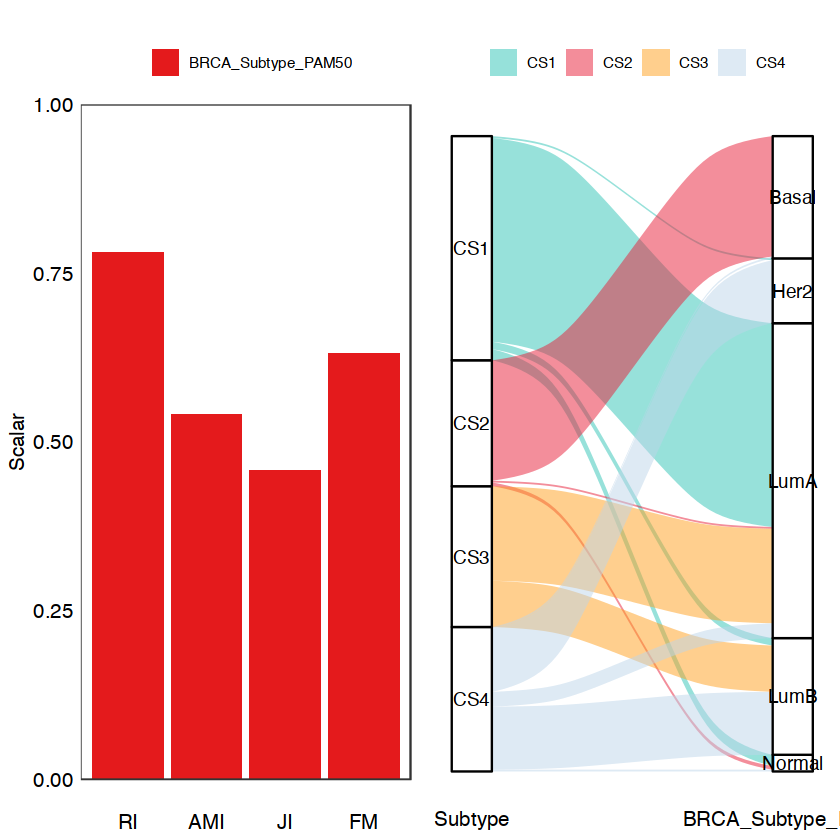

In [28]:
# compare agreement with other subtypes
sub_df = data.frame(
                    BRCA_Subtype_PAM50 = brca_dat[["clinical"]][,c("BRCA_Subtype_PAM50")])
rownames(sub_df) = brca_dat[["clinical"]][,c("bcr_patient_barcode")]
head(sub_df)

# agreement comparison (support up to 6 classifications include current subtype)
agree.brca <- compAgree(moic.res  = cmoic.brca,
                        subt2comp = sub_df,
                        doPlot    = TRUE,
                        box.width = 0.2,
                        fig.name  = "AGREEMENT OF CONSENSUSMOIC WITH PAM50 Subtype")

## Other Functions in the COMP Module

MOVICS provides additional functionality to compare the subtypes. I've outlined them below:

* Mutational frequency: compMut()
    * applies Fisher's exact test or $\chi^2$ tests for each mutation; also provides OncoPrint
* Total mutation burden: compTMB()
    * TMB is the number of mutations that are found in tumor genome; useful for characterizing the genomic make-up of tumors
* Fraction genome altered (FGA): compFGA()
    * FGA is the percentage of genome that has been affected by copy number gains or losses; also separated into specific gain (FGG) or loss (FGL) per sample; also helps characterize the genomic make-up of the tumor
* Drug sensitivity: compDrugsen()
    * refers to R package pRRophetic to predict clinical chemotherapeutic response from tumor gene expression levels (Geeleher 2014)


# Analyzing Subtypes for Predictive Biomarkers and Functional Pathways: RUN Module

We can now examine the omic-profiles of our subtypes to identify potential predictive biomarkers and functional pathways. 

## Differential Expression (DE)

We will start with a differential expression analysis (DE). MOVICS provides 3 methods: edgeR and DESeq2 for RNA-Seq count data; and limma for microarray profile or normalized expression data. The function runDEA will output several .txt files storing differential expression analysis results by specified algorithm into the directory we specify (or working directory by default) with a string denoted by the prefix argument. We will reference this prefix in the following commands to identify these files. Each identified cancer subtype will be compared with the rest (Others).

Since our RNA expression data comes from a microarray, we'll use limma.

**Note: since runDEA() checks the data scale automatically when choosing limma algorithm, it is recommended to provide a microarray expression profile or normalized expression data (e.g., RSEM, FPKM, TPM) without z-score or log2 transformation.**

In [29]:
# run DEA with limma
runDEA(dea.method = "limma",
       expr       = brca_dat[["MO"]][["Expression"]], # normalized expression data
       moic.res   = cmoic.brca,
       overwt = T,
       res.path   = getwd(), # path to save marker files
       prefix     = "de_TCGA-BRCA")


--all samples matched.

--you choose limma and please make sure a microarray profile or a normalized expression data [FPKM or TPM without log2 transformation is recommended] was provided.

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.



limma of CS1_vs_Others done...
limma of CS2_vs_Others done...
limma of CS3_vs_Others done...
limma of CS4_vs_Others done...


## Biomarker Identification

Now, we'll identify significantly overexpressed and underexpressed genes for each subtype with runMarker(). In this procedure, the most differentially expressed genes sorted by log2FoldChange are chosen as the biomarkers for each subtype (200 biomarkers for each subtype by default). These biomarkers should pass the significance threshold (e.g., nominal p-value < 0.05 and adjusted p-value < 0.05) and must not overlap with any biomarkers identified for other subtypes.
Top markers will be chosen to generate a template so as to run nearest template prediction for subtype verification.

The function will output the following: 

* A figure of subtype-specific marker heatmap (.pdf) if doPlot = TRUE

and a list with the following components:

* unqlist: a string vector storing the unique marker across all subtypes

* templates: a data.frame storing the the template information for nearest template prediction, which is used for verification in external cohort

* dirct: a string value indicating the direction for identifying subtype-specific markers

* heatmap: a complexheatmap object

--all samples matched.

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.



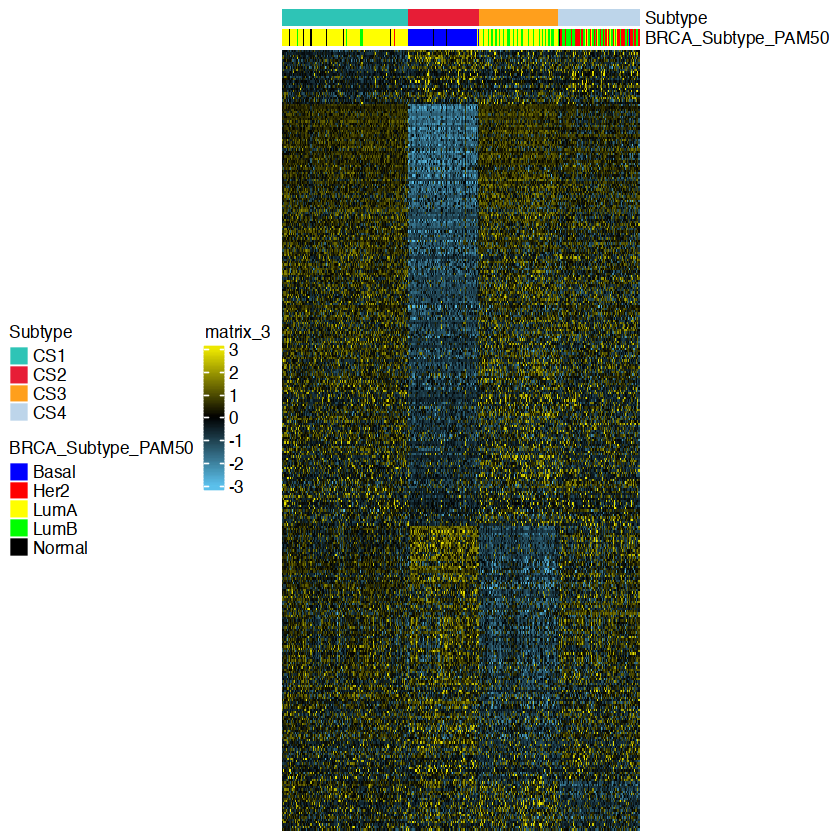

In [30]:
# choose limma result to identify subtype-specific DOWN-regulated biomarkers
marker.dn <- runMarker(moic.res      = cmoic.brca,
                       dea.method    = "limma",
                       prefix        = "de_TCGA-BRCA",
                       dirct         = "down",
                       dat.path = getwd(),
                       res.path = getwd(),
                       p.cutoff      = 0.05, # p cutoff to identify significant DEGs
                       p.adj.cutoff  = 0.05, # padj cutoff to identify significant DEGs                       
                       n.marker      = 200, # number of biomarkers for each subtype
                       doplot        = T,
                       annCol        = annCol,
                       annColors     = annColors,
                       norm.expr     = brca_dat[["MO"]][["Expression"]],
                       fig.name      = "UPREGULATED BIOMARKER HEATMAP")


--all samples matched.

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.



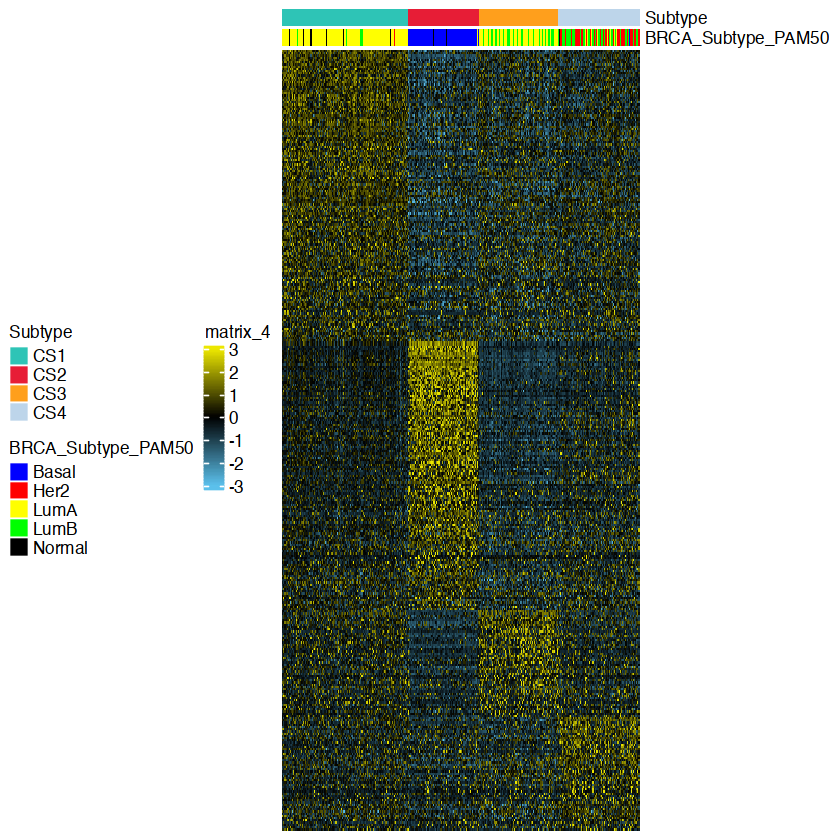

In [31]:
# subtype-specific UP-regulated biomarkers
marker.up <- runMarker(moic.res      = cmoic.brca,
                       dea.method    = "limma",
                       prefix        = "de_TCGA-BRCA",
                       dirct         = "up",
                       dat.path = getwd(),
                       res.path = getwd(),
                       p.cutoff      = 0.05, # p cutoff to identify significant DEGs
                       p.adj.cutoff  = 0.05, # padj cutoff to identify significant DEGs                       
                       n.marker      = 200, # number of biomarkers for each subtype
                       doplot        = T,
                       annCol        = annCol,
                       annColors     = annColors,
                       norm.expr     = brca_dat[["MO"]][["Expression"]],
                       fig.name      = "UPREGULATED BIOMARKER HEATMAP")


## Gene Set Enrichment

Now, we'll use runGSEA to perform gene set enrichment for our up- and down-regulated genes to identify subtype-specific (overexpressed or downexpressed) functional pathways. We'll use the background gene list (from Molecular Signature Database http://www.gsea-msigdb.org/gsea/msigdb/index.jsp; "MSigDB") provided by the MOVICS package, but you can download your own. You just need to specify the ABSOLUTE path for the file.

Here, we'll identify specific pathways that pass a significance threshold with nominal p-value < 0.05 and adjusted p-value < 0.25, and must not overlap with any pathways identified for other subtypes. After having the subtype-specific pathways, genes that are inside the pathways are retrieved to calculate a single sample enrichment score by using GSVA R package. Subsequently, subtype-specific enrichment score will be represented by the mean or median (mean by default) value within the subtype, and will be further visualized by diagonal heatmap.

There are arguments to specify the method the minimum and maximum sizes to identify gene sets (by default: minGSSize = 10 and maxGSSize = 500). Additionally, you can chose from a couple of different methods to estimate gene-set enrichment scores (gsva.method, input choice as string). By default this is set to gsva (Hänzelmann et al, 2013) and other options are ssgsea (Barbie et al, 2009), zscore (Lee et al, 2008) or plage (Tomfohr et al, 2005). The latter two standardize first expression profiles into z-scores over the samples and, in the case of zscore, it combines them together as their sum divided by the square-root of the size of the gene set, while in the case of plage they are used to calculate the singular value decomposition (SVD) over the genes in the gene set and use the coefficients of the first right-singular vector as pathway activity profile.

The function will output the folowing:

* A figure of subtype-specific pathway heatmap (.pdf) and a list with the following components:

    * gsea.list: a list storing gsea object returned by GSEA for each subtype

    * raw.es: a data.frame storing raw enrichment score of identified subtype-specific pathways by using specified gsva.method

    * scaled.es: a data.frame storing z-scored enrichment score of identified subtype-specific pathways by using specified gsva.method

    * grouped.es: a data.frame storing grouped enrichment score (mean or median value among each subtype) by using specified norm.method

    * heatmap: a complexheatmap object.

--all samples matched.

GSEA done...

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.



Estimating GSVA scores for 24 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



gsva done...

heatmap done...



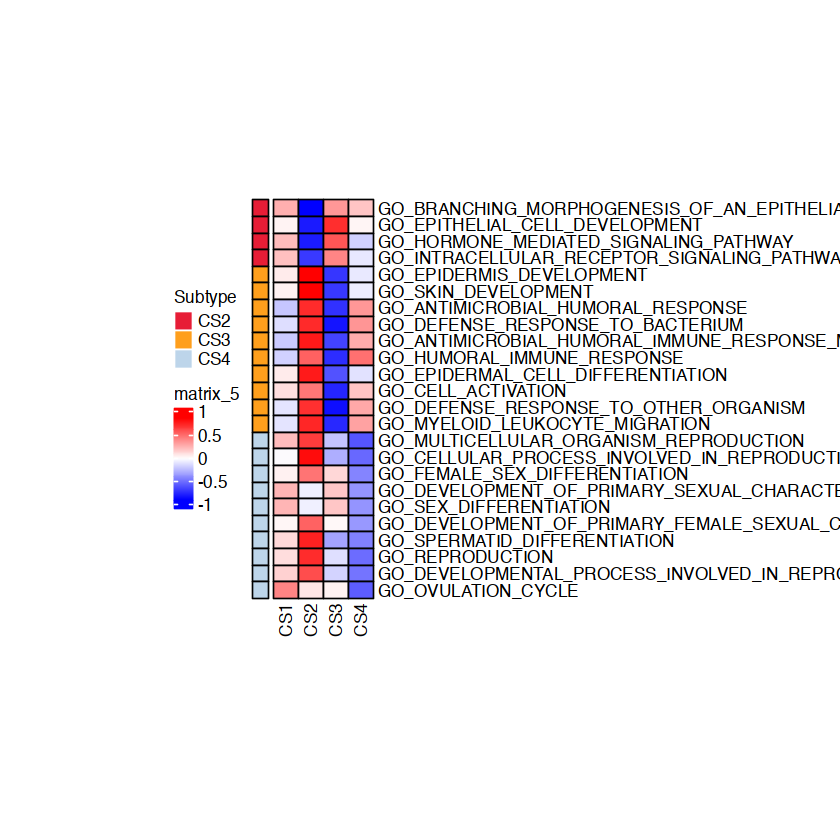

In [32]:
# MUST locate ABSOLUTE path of msigdb file
MSIGDB.FILE <- system.file("extdata", "c5.bp.v7.1.symbols.xls", package = "MOVICS", mustWork = TRUE)

# # run GSEA to identify DOWN-regulated GO pathways using results from edgeR
gsea.down <- runGSEA(moic.res     = cmoic.brca,
                   dea.method   = "limma", # name of DEA method
                   prefix       = "de_TCGA-BRCA", # MUST be the same of argument in runDEA()
                   dat.path     = getwd(), # path of DEA files
                   res.path     = getwd(), # path to save GSEA files
                   msigdb.path  = MSIGDB.FILE, # MUST be the ABSOLUTE path of msigdb file
                   norm.expr    = brca_dat[["MO"]][["Expression"]], # use normalized expression to calculate enrichment score
                   dirct        = "down", # direction of dysregulation in pathway
                   p.cutoff     = 0.05, # p cutoff to identify significant pathways
                   p.adj.cutoff = 0.25, # padj cutoff to identify significant pathways
                   gsva.method  = "gsva", # method to calculate single sample enrichment score
                   norm.method  = "mean", # normalization method to calculate subtype-specific enrichment score
                   fig.name     = "DOWNREGULATED PATHWAY HEATMAP")


Let's check some columns of GSEA results for the second subtype (CS2):

In [34]:
data.frame(gsea.down$gsea.list$CS2[1:6,3:6])

setSize
GO_CYTOSKELETON_ORGANIZATION                                           31     
GO_SKIN_DEVELOPMENT                                                    35     
GO_EPIDERMIS_DEVELOPMENT                                               40     
GO_KERATINIZATION                                                      21     
GO_CORNIFICATION                                                       19     
GO_CELLULAR_PROCESS_INVOLVED_IN_REPRODUCTION_IN_MULTICELLULAR_ORGANISM 22     
                                                                       enrichmentScore
GO_CYTOSKELETON_ORGANIZATION                                           0.5421869      
GO_SKIN_DEVELOPMENT                                                    0.5103554      
GO_EPIDERMIS_DEVELOPMENT                                               0.4854447      
GO_KERATINIZATION                                                      0.5686062      
GO_CORNIFICATION                                                       0.5887244      
GO_CELLULAR_PROCESS_INVOLVED_IN_REPRODUCTION_IN_MULTICELLULAR_ORGANISM 0.5638868      
                                                                       NES     
GO_CYTOSKELETON_ORGANIZATION                                           2.115719
GO_SKIN_DEVELOPMENT                                                    2.051376
GO_EPIDERMIS_DEVELOPMENT                                               2.001070
GO_KERATINIZATION                                                      1.999748
GO_CORNIFICATION                                                       1.983654
GO_CELLULAR_PROCESS_INVOLVED_IN_REPRODUCTION_IN_MULTICELLULAR_ORGANISM 1.980757
                                                                       pvalue     
GO_CYTOSKELETON_ORGANIZATION                                           0.002557545
GO_SKIN_DEVELOPMENT                                                    0.002570694
GO_EPIDERMIS_DEVELOPMENT                                               0.002597403
GO_KERATINIZATION                                                      0.002512563
GO_CORNIFICATION                                                       0.002538071
GO_CELLULAR_PROCESS_INVOLVED_IN_REPRODUCTION_IN_MULTICELLULAR_ORGANISM 0.002645503

Let's also look at the results of subtype-specific enrichment scores:

In [35]:
head(round(gsea.down$grouped.es,3))

CS1   CS2    CS3    CS4   
GO_BRANCHING_MORPHOGENESIS_OF_AN_EPITHELIAL_TUBE 0.249 -0.907  0.333  0.175
GO_EPITHELIAL_CELL_DEVELOPMENT                   0.010 -0.816  0.693  0.005
GO_HORMONE_MEDIATED_SIGNALING_PATHWAY            0.204 -0.814  0.556 -0.187
GO_INTRACELLULAR_RECEPTOR_SIGNALING_PATHWAY      0.190 -0.709  0.395 -0.104
GO_EPIDERMIS_DEVELOPMENT                         0.038  0.853 -0.718 -0.098
GO_SKIN_DEVELOPMENT                              0.016  0.852 -0.712 -0.085

--all samples matched.

GSEA done...

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.



Estimating GSVA scores for 27 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



gsva done...

heatmap done...



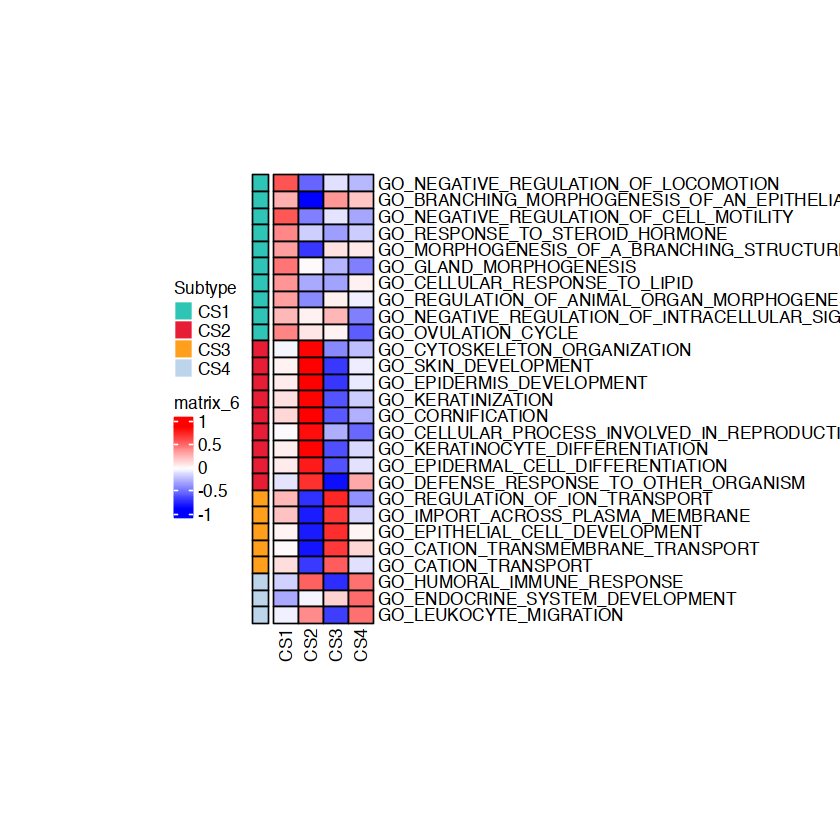

In [33]:
# # run GSEA to identify up-regulated GO pathways using results from limma
gsea.up <- runGSEA(moic.res     = cmoic.brca,
                   dea.method   = "limma", # name of DEA method
                   prefix       = "detesting_TCGA-BRCA", # MUST be the same of argument in runDEA()
                   dat.path     = getwd(), # path of DEA files
                   res.path     = getwd(), # path to save GSEA files
                   msigdb.path  = MSIGDB.FILE, # MUST be the ABSOLUTE path of msigdb file
                   norm.expr    = brca_dat[["MO"]][["Expression"]], # use normalized expression to calculate enrichment score
                   dirct        = "up", # direction of dysregulation in pathway
                   p.cutoff     = 0.05, # p cutoff to identify significant pathways
                   p.adj.cutoff = 0.25, # padj cutoff to identify significant pathways
                   gsva.method  = "gsva", # method to calculate single sample enrichment score
                   norm.method  = "mean", # normalization method to calculate subtype-specific enrichment score
                   fig.name     = "UPREGULATED PATHWAY HEATMAP")


## Gene Set Variation Analysis

Now, we'll run gene set variation analysis with runGSVA to calculate enrichment scores of each sample in each subtype based on given gene set list of interest. For all the new defined molecular subtypes, we can depict their characteristics with different signatures of gene sets.

Again, we'll just use the gene list provided by the MOVICS package, but you can use your own by specifying its absolute file path.

For the normalized expression data (norm.expr), you provide a matrix of normalized expression data with rows for genes and columns for samples, and FPKM or TPM without log2 transformation is recommended. You can also change the linkage and distance (by default, ward.D and euclidean) for the hierarchical clustering, if you wish.


--all samples matched.

--expression profile seems to have been standardised (z-score or log transformation), no more action will be performed.

Warning message in .gsva(expr, mapped.gset.idx.list, method, kcdf, rnaseq, abs.ranking, :
"Some gene sets have size one. Consider setting 'min.sz > 1'."


Estimating GSVA scores for 15 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



gsva done...



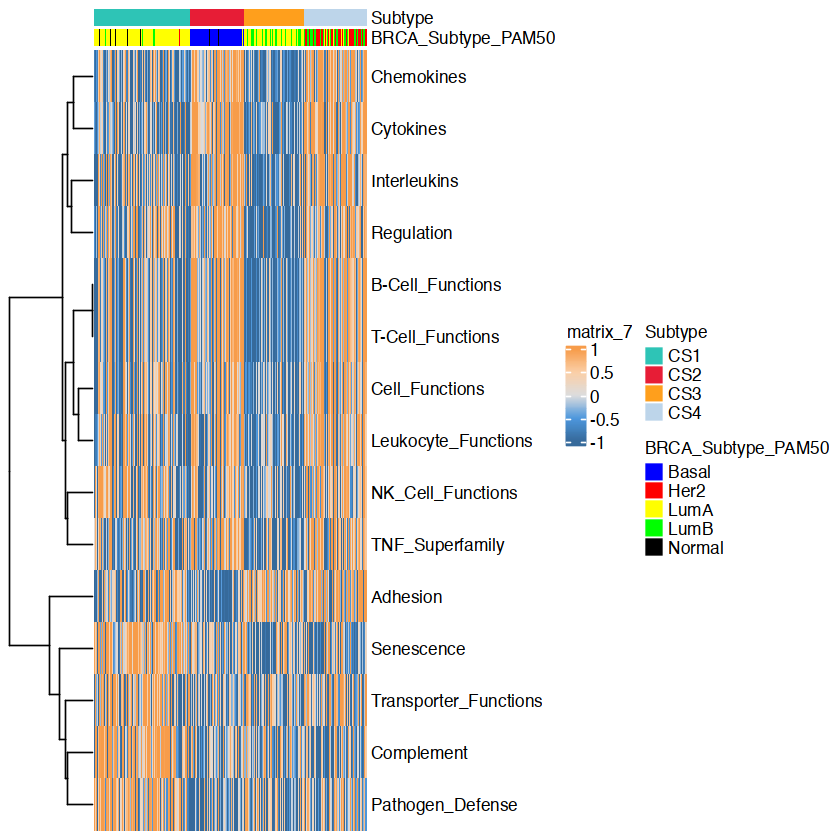

In [36]:
# MUST locate ABSOLUTE path of gene set file
GSET.FILE <- 
  system.file("extdata", "gene sets of interest.gmt", package = "MOVICS", mustWork = TRUE)

# run GSVA to estimate single sample enrichment score based on given gene set of interest
gsva.res <- 
  runGSVA(moic.res      = cmoic.brca,
          norm.expr     = brca_dat[["MO"]][["Expression"]],
          gset.gmt.path = GSET.FILE, # ABSOLUTE path of gene set file
          gsva.method   = "gsva", # method to calculate single sample enrichment score
          annCol        = annCol,
          annColors     = annColors,
          fig.path      = getwd(),
          fig.name      = "GENE SETS OF INTEREST HEATMAP",
          height        = 5,
          width         = 10)


In [37]:
message("check raw enrichment score")
gsva.res$raw.es[1:3,1:3]

message("check z-scored and truncated enrichment score")
gsva.res$scaled.es[1:3,1:3]


check raw enrichment score



TCGA-A1-A0SH TCGA-A1-A0SJ TCGA-A1-A0SK
Adhesion         -0.6987578   -0.5652174   -0.8881988  
B-Cell_Functions -0.6623658   -0.5763203   -0.2251247  
Cell_Functions   -0.4728424   -0.4048822   -0.1318637

check z-scored and truncated enrichment score



TCGA-A1-A0SH TCGA-A1-A0SJ TCGA-A1-A0SK
Adhesion         -1           -0.9281357   -1.0000000  
B-Cell_Functions -1           -1.0000000   -0.4259172  
Cell_Functions   -1           -1.0000000   -0.3021437

# Additional Functionality in the RUN Module

* Evaluating with external cohort
    * compare the subtypes with current defined subtypes in an external cohort; this includes 2 model-free approachs for subtype prediction
         * Nearest template prediction (NTP) runNTP: can be used cross-platform, cross-species, and does not require optimization of analysis parameters
        * Partition around mediods classifier runPAM(): trains a partition around medoids (PAM) classifier with training cohort, predict subtypes in validation cohort, assign each sample in validation cohort to subtype with centroid with the highest Pearson correlation iwth the sample
        * test consistency of the NTP and PAM results with runKapa()

# Summary

In summary, today we have explored the MOVICS R package to perform unsupervised multi-omics clustering for some gene expression, methylation, and miRNA expression data for a subset of subjects with breast cancer from TCGA's BRCA cohort. Using this package, we can identify the top markers (most variable genes, probes, etc) and impute any values with knn if needed. We can estimate the best number of clusters *k* we'd like to use using Gap and CPI statistics, but we should keep in mind prior/biologic knowledge when choosing this value. To perform the clustering, we can choose from 10 different clustering algorithms. Here, we used SNF, PINSPlus, NEMO, LRAcluster, and IntNMF. Then, to improve the robustness of our results, we can calculate a consensus matrix from the clusterings identified across these methods. We will then get *k* clusters with distinct omics profiles.

From the consensus matrix and the identified subtypes, we can compare survival times, clinical features, matching with other, previously-defined types, and more. We can also compare the omic profiles of our subtypes with differential expression analysis, biomarker identification, gene set enrichment, and gene set variation analysis.

In our example data, we found some strong correspondence between an identified subtype (CS2) and the basal PAM50 class. This subtype appeared to have a strong signal in the mRNA expression and DNA methylation data, with a slightly less noticeable signature in the miRNA expression. When comparing to the other subtypes, it seemed to have the strongest signals across all omics data types. The distinctness of this cluster was further shown in our biomarker identification analyses and GSEA.

We also identified 2 subtypes (CS1 & 3) who had distinctly different mRNA expression profiles. Though a bit weaker, there were also differences in the DNA methylation and miRNA expression profiles between the subtypes. Most of CS1 corresponded to those with Luminal A classification. However, CS3 was a little less clear-cut and had subjects with both Luminal A and B classifications.

CS4 showed little distinct signatures in the omics profiles and a hodgepodge of the PAM50 classes. We likely can't characterize these subjects well with our data.

Thank you for attending this presentation and go forth and explore your own multi-omics data!

# References & Citations

For now, if you use MOVICS R package in published research, please cite:
* Lu, X., Meng, J., Zhou, Y., Jiang, L., and Yan, F. (2020). MOVICS: an R package for multi-omics integration and visualization in cancer subtyping. bioRxiv, 2020.2009.2015.297820. [doi.org/10.1101/2020.09.15.297820]

Please cite corresponding literature below for multi-omic clustering algorithm if used:
* CIMLR: Ramazzotti D, Lal A, Wang B, Batzoglou S, Sidow A (2018). Multi-omic tumor data reveal diversity of molecular mechanisms that correlate with survival. Nat Commun, 9(1):4453.
* iClusterBayes: Mo Q, Shen R, Guo C, Vannucci M, Chan KS, Hilsenbeck SG (2018). A fully Bayesian latent variable model for integrative clustering analysis of multi-type omics data. Biostatistics, 19(1):71-86.
* Mocluster: Meng C, Helm D, Frejno M, Kuster B (2016). moCluster: Identifying Joint Patterns Across Multiple Omics Data Sets. J Proteome Res, 15(3):755-765.
* COCA: Hoadley KA, Yau C, Wolf DM, et al (2014). Multiplatform analysis of 12 cancer types reveals molecular classification within and across tissues of origin. Cell, 158(4):929-944.
* ConsensusClustering: Monti S, Tamayo P, Mesirov J, et al (2003). Consensus Clustering: A Resampling-Based Method for Class Discovery and Visualization of Gene Expression Microarray Data. Mach Learn, 52:91-118.
* IntNMF: Chalise P, Fridley BL (2017). Integrative clustering of multi-level omic data based on non-negative matrix factorization algorithm. PLoS One, 12(5):e0176278.
* LRAcluster: Wu D, Wang D, Zhang MQ, Gu J (2015). Fast dimension reduction and integrative clustering of multi-omics data using low-rank approximation: application to cancer molecular classification. BMC Genomics, 16(1):1022.
* NEMO: Rappoport N, Shamir R (2019). NEMO: cancer subtyping by integration of partial multi-omic data. Bioinformatics, 35(18):3348-3356.
* PINSPlus: Nguyen H, Shrestha S, Draghici S, Nguyen T (2019). PINSPlus: a tool for tumor subtype discovery in integrated genomic data. Bioinformatics, 35(16):2843-2846.
* SNF: Wang B, Mezlini AM, Demir F, et al (2014). Similarity network fusion for aggregating data types on a genomic scale. Nat Methods, 11(3):333-337.

Heatmap generated by MOVICS uses ComplexHeatmap R package, so please cite if any heatmap is created:
* Gu Z, Eils R, Schlesner M (2016). Complex heatmaps reveal patterns and correlations in multidimensional genomic data. Bioinformatics, 32(18):2847–2849.

If FLAGS is removed when calculating TMB, please cite the following two at the same time, otherwise only the first one:
* Mayakonda A, Lin D C, Assenov Y, et al. (2018). Maftools: efficient and comprehensive analysis of somatic variants in cancer. Genome Res, 28(11):1747-1756.
* Shyr C, Tarailo-Graovac M, Gottlieb M, Lee JJ, van Karnebeek C, Wasserman WW. (2014). FLAGS, frequently mutated genes in public exomes. BMC Med Genomics, 7(1): 1-14.

If calculating FGA, please cite:
* Cerami E, Gao J, Dogrusoz U, et al. (2012). The cBio Cancer Genomics Portal: An Open Platform for Exploring Multidimensional Cancer Genomics Data. Cancer Discov, 2(5):401-404.
* Gao J, Aksoy B A, Dogrusoz U, et al. (2013). Integrative analysis of complex cancer genomics and clinical profiles using the cBioPortal. Sci Signal, 6(269):pl1-pl1.


Drug sensitivity analysis is based on pRRophetic R package, so please cite:
* Geeleher P, Cox N, Huang R S (2014). pRRophetic: an R package for prediction of clinical chemotherapeutic response from tumor gene expression levels. PLoS One, 9(9):e107468.
* Geeleher P, Cox N J, Huang R S (2014). Clinical drug response can be predicted using baseline gene expression levels and in vitro drug sensitivity in cell lines. Genome Biol, 15(3):1-12.
  Please cite corresponding literature below if using differential expression analysis:

edgeR:
    * Robinson MD, McCarthy DJ, Smyth GK (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1):139-140.
    * McCarthy DJ, Chen Y, Smyth GK (2012). Differential expression analysis of multifactor RNA-Seq experiments with respect to biological variation. Nucleic Acids Res. 40(10):4288-4297.
* DESeq2: Love MI, Huber W, Anders S (2014). Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biol, 15(12):550-558.
* limma: Ritchie ME, Phipson B, Wu D, Hu Y, Law CW, Shi W, Smyth GK (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res, 43(7):e47.


Gene set enrichment analysis uses clusterProfiler R package with the following paper:
* Yu G, Wang L, Han Y, He Q (2012). clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS, 16(5):284-287.
* Subramanian A, Tamayo P, Mootha V K, et al. (2005). Gene set enrichment analysis: a knowledge-based approach for interpreting genome-wide expression profiles. Proc Natl Acad Sci, 102(43):15545-15550.


For single sample enrichment analysis, please cite literature below appropriately:
* ssgsea: Barbie, D.A. et al (2009). Systematic RNA interference reveals that oncogenic KRAS-driven cancers require TBK1. Nature, 462(5):108-112.
* gsva: Hänzelmann, S., Castelo, R. and Guinney, J. (2013). GSVA: Gene set variation analysis for microarray and RNA-Seq data. BMC Bioinformatics, 14(1):7.
* zscore: Lee, E. et al (2008). Inferring pathway activity toward precise disease classification. PLoS Comp Biol, 4(11):e1000217.
* plage: Tomfohr, J. et al (2005). Pathway level analysis of gene expression using singular value decomposition. BMC Bioinformatics, 6(1):1-11.


External validation uses nearest template prediction as implanted in CMScaller R package. Please cite:
* Eide P W, Bruun J, Lothe R A, et al. (2017). CMScaller: an R package for consensus molecular subtyping of colorectal cancer pre-clinical models. Sci Rep, 7(1):1-8.
* Hoshida, Y. (2010). Nearest Template Prediction: A Single-Sample-Based Flexible Class Prediction with Confidence Assessment. PLoS One, 5(11):e15543.


If using partition around medoids classifier, then cite:
* Tibshirani R, Hastie T, Narasimhan B and Chu G (2002). Diagnosis of multiple cancer types by shrunken centroids of gene expression. Proc Natl Acad Sci, 99,6567–6572.
* Kapp A V, Tibshirani R. (2007). Are clusters found in one dataset present in another dataset? Biostatistics, 8(1):9-31.
